# AP-1 RNA-seq Analysis

In [4]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
### imports ###
import sys
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
from mpl_toolkits.mplot3d import Axes3D
from matplotlib_venn import venn3, venn2
import pickle
from matplotlib import patches as mpatches
%matplotlib inline
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
sns.set_context('notebook')

## Preprocessing

In [90]:
# file directories
workingDirectory = '/home/jenhan/analysis/ap1_rna_analysis/'
binDirectory = '/home/jenhan/bin/'
genomePath = '/bioinformatics/homer/data/genomes/mm10'
genomes = ['hg19','mm10', 'hg38']
peakDirectory = workingDirectory + 'peaks/'
scratchDirectory = workingDirectory + '/scratch/'
logFilePath = workingDirectory + '/log_files/'
tagDirPath = workingDirectory + '/tag_directories/'
inputDirectory = workingDirectory + '/input/'
idrDirectory = workingDirectory + '/idr/'


os.chdir(workingDirectory)



In [91]:
strains = []
treatments = []
owners = []
dates = []
originalNames = []
targets = []
for f in os.listdir(tagDirPath):
    originalName = f
    metaDataTokens = f.split('_')
    
    originalNames.append(originalName)
    # grab metadata from string tokens
    strain = metaDataTokens[0].strip()
    target = metaDataTokens[4].strip()
    treatment = metaDataTokens[3].strip().split('-')[0]
    owner = metaDataTokens[5].strip()
    date = metaDataTokens[6].strip()
    
    # append to overall lists
    strains.append(strain)
    treatments.append(treatment)
    owners.append(owner)
    dates.append(date)
    targets.append(target)
metadata_frame = pd.DataFrame([strains, 
                                  targets,
                                  treatments, 
                                  owners, 
                                  originalNames, 
                                  ]).transpose()
metadata_frame.columns = ['strain', 
                          'target',
                         'treatment',
                         'owner', 
                         'sampleName']

# ### read in log files ###

# create data frame summarizing mapping quality logs

# from tagInfo.txt
_originalNames =[]
_totalReads = []
_fragmentLengthEstimate =[]
_peakSizeEstimate = []
_tagsPerBP = []
_averageTagsPerPosition = []
_averageTagLength = []
_averageFragmentGCcontent = []


for tagdir in os.listdir(tagDirPath):
    with open(tagDirPath + '/' + tagdir + '/tagInfo.txt') as f:
        data = f.readlines()
        _originalNames.append(tagdir)
        _fragmentLengthEstimate.append(float(data[2].strip().split('=')[1]))
        _peakSizeEstimate.append(float(data[3].strip().split('=')[1]))
        _tagsPerBP.append(float(data[4].strip().split('=')[1]))
        _averageTagsPerPosition.append(float(data[5].strip().split('=')[1]))
        _averageTagLength.append(float(data[6].strip().split('=')[1]))
        _averageFragmentGCcontent.append(float(data[8].strip().split('=')[1]))
        _totalReads.append(float(data[1].split()[2]))
mappingStats_frame = pd.DataFrame([_originalNames,
                                   _totalReads, 

                                   _fragmentLengthEstimate,
                                   _peakSizeEstimate,
                                   _tagsPerBP,
                                   _averageTagsPerPosition,
                                   _averageTagLength,
                                   _averageFragmentGCcontent,
                                  ]).transpose()
mappingStats_frame.columns = ['sampleName',
                              'totalReads', 
                              'fragmentLengthEstimate',
                              'peakSizeEstimate',
                              'tagsPerBP',
                              'averageTagsPerPosition',
                              'averageTagLength',
                              'averageFragmentGCcontent']

summary_frame = metadata_frame.merge(mappingStats_frame, on='sampleName')


summary_frame.index  = pd.MultiIndex.from_arrays([list(summary_frame['strain'].values),
                                                  list(summary_frame['target'].values),
                                                  list(summary_frame['treatment'].values)])
summary_frame = summary_frame.sort()
summary_frame.to_csv('qc_metrics_rna.tsv', sep='\t', index=False)
summary_frame_rna = summary_frame.copy()

## Mapping Quality Control

### Plot Distributions of Mapping Statistics

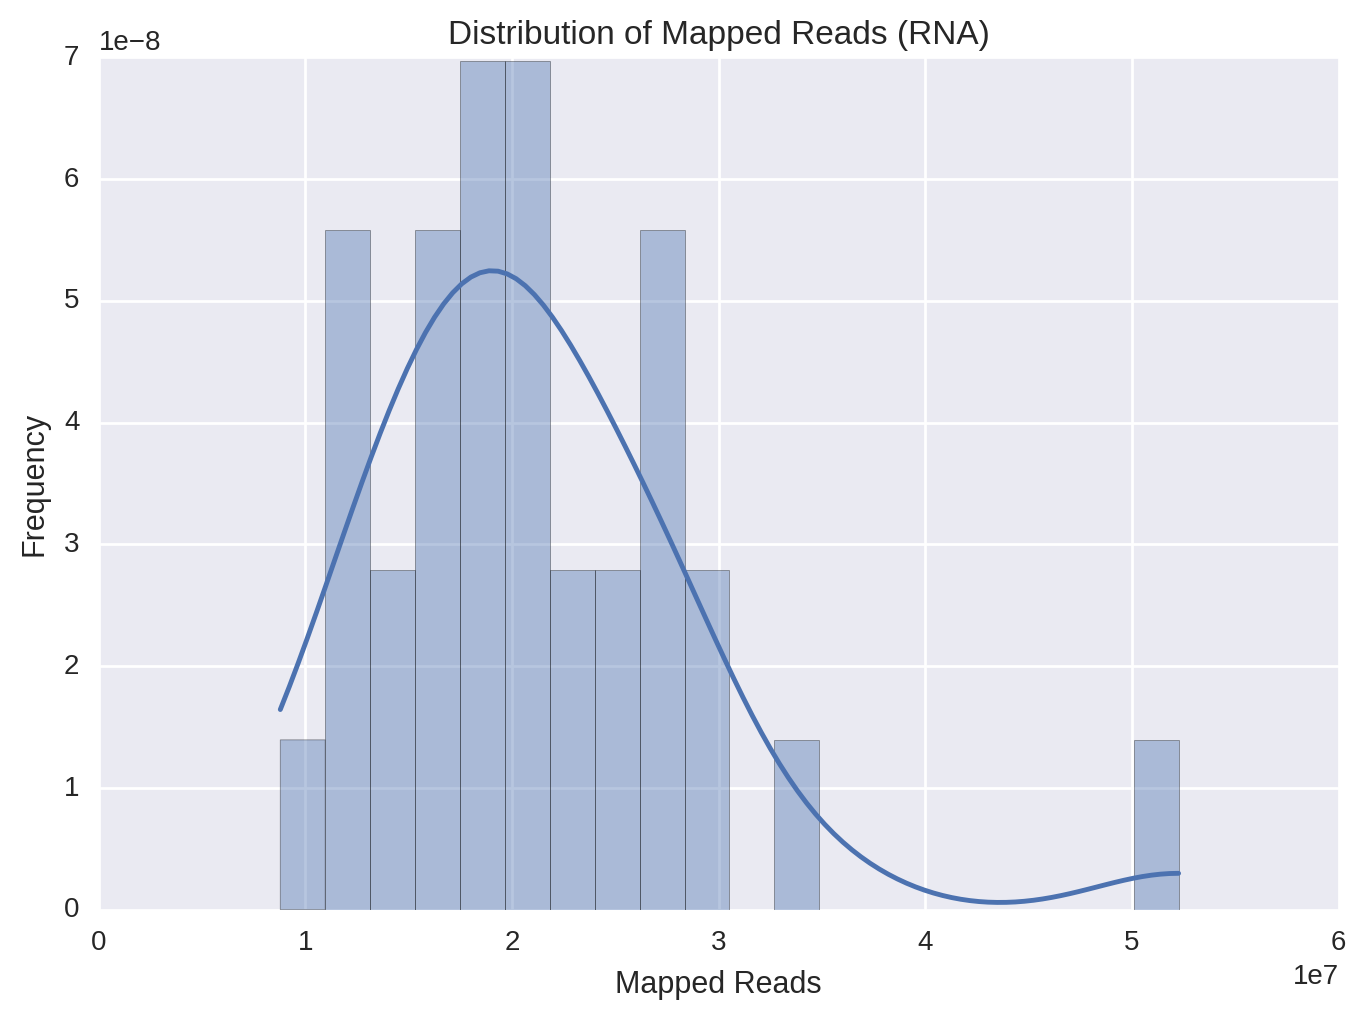

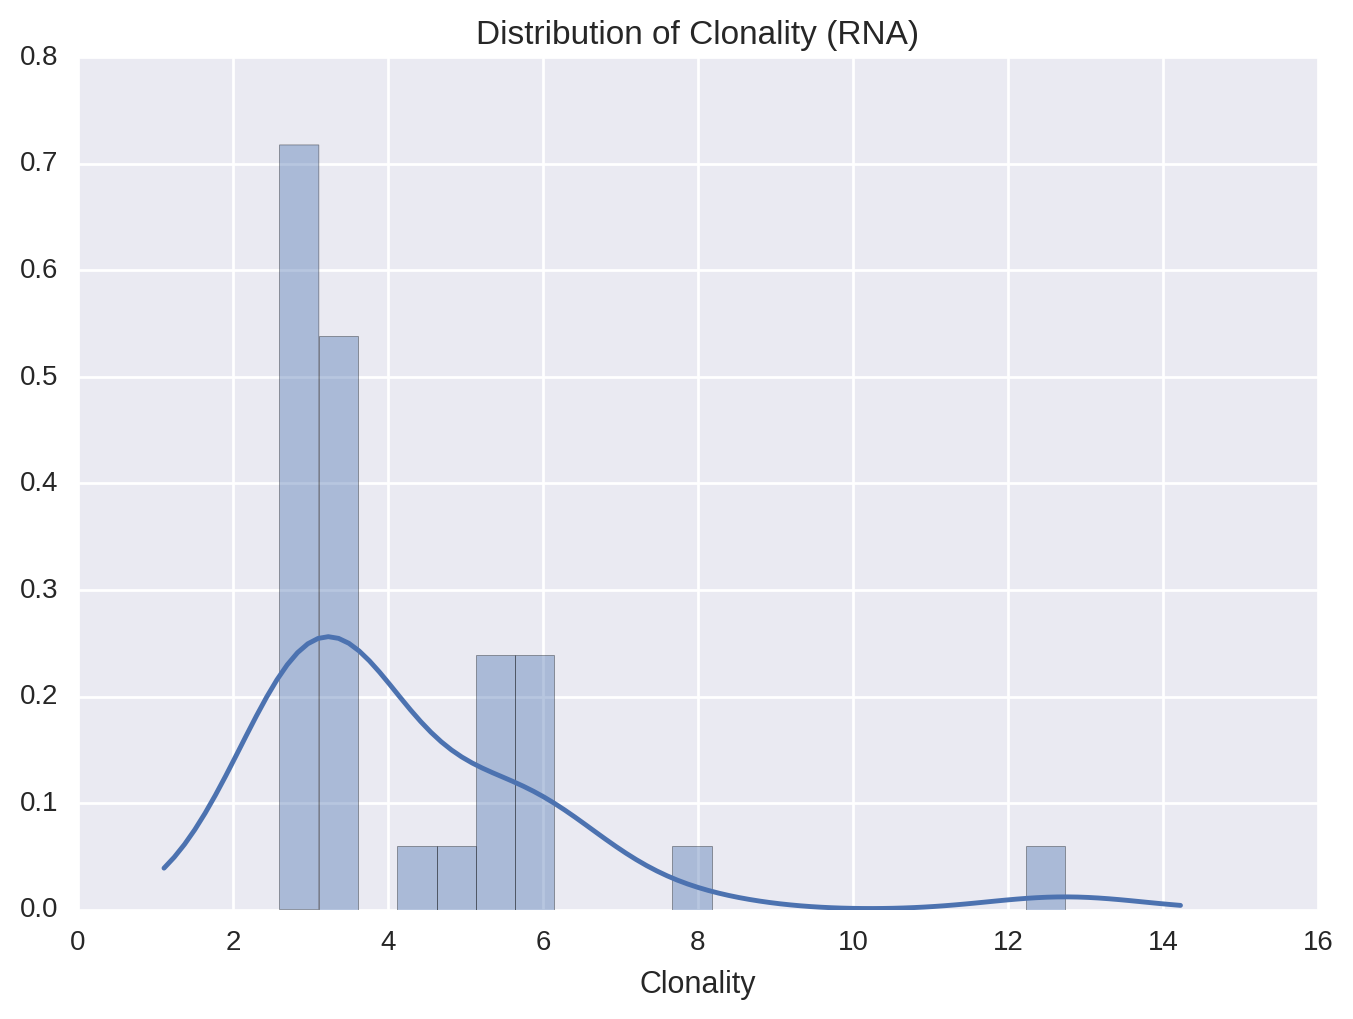

In [92]:
sns.distplot(summary_frame_rna['totalReads'], bins=20, kde=True)
plt.title('Distribution of Mapped Reads (RNA)')
plt.xlabel('Mapped Reads')
plt.ylabel('Frequency')
plt.show()

sns.distplot(summary_frame_rna['averageTagsPerPosition'], bins=20)
plt.title('Distribution of Clonality (RNA)')
plt.xlabel('Clonality')
plt.show()


### Filter Samples According to Mapping Quality

In [230]:
# filter samples according to threshold for the fraction of uniquely mapped reads
readsThreshold = 1000000
pbcThreshold=0.0
# gcThreshold=0.10
clonalityThreshold = 20
# spotThreshold = 0.005

filtered_summary_frame_rna = summary_frame_rna.copy()

filtered_summary_frame_rna = filtered_summary_frame_rna[filtered_summary_frame_rna['totalReads'] >= readsThreshold]

filtered_summary_frame_rna = filtered_summary_frame_rna[filtered_summary_frame_rna['averageTagsPerPosition'] <= clonalityThreshold]

filtered_summary_frame_rna = filtered_summary_frame_rna[~filtered_summary_frame_rna['sampleName'].str.contains('16-02-04')]

## Calculate Tag Counts and RPKM

In [233]:
filteredTagDirectories = ' '.join(['/home/jenhan/analysis/ap1_rna_analysis/tag_directories/' +x for x in filtered_summary_frame_rna['sampleName']])
filteredTagDirectories_veh = ' '.join(['/home/jenhan/analysis/ap1_rna_analysis/tag_directories/' + x 
 for x in filtered_summary_frame_rna['sampleName'] if 'Veh' in x and 'Ctrl' in x] + \
['/home/jenhan/analysis/ap1_rna_analysis/tag_directories/' + x 
 for x in filtered_summary_frame_rna['sampleName'] if 'Veh' in x and not 'Ctrl' in x])
filteredTagDirectories_kla = ' '.join(['/home/jenhan/analysis/ap1_rna_analysis/tag_directories/' + x 
 for x in filtered_summary_frame_rna['sampleName'] if 'KLA' in x and 'Ctrl' in x] + \
['/home/jenhan/analysis/ap1_rna_analysis/tag_directories/' + x 
 for x in filtered_summary_frame_rna['sampleName'] if 'KLA' in x and not 'Ctrl' in x])

filteredTagDirectories_base = ' '.join(['/home/jenhan/analysis/ap1_rna_analysis/tag_directories/' + x 
 for x in filtered_summary_frame_rna['sampleName'] if '_UT_' in x or 'Ctrl' in x])

# filteredTagDirectories_single = ' '.join(
#     ['/home/jenhan/analysis/ap1_rna_analysis/tag_directories/' +
#      x for x in filtered_summary_frame_rna['sampleName'] if not '16-02-04' in x])


# !analyzeRepeats.pl rna mm10 -count exons -condenseGenes -rpkm -d $filteredTagDirectories > rpkm.tsv
# !analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories > raw.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories_veh > raw_veh.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories_kla > raw_kla.tsv
!analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories_base > raw_base.tsv
# !analyzeRepeats.pl rna mm10 -count exons -condenseGenes -noadj -d $filteredTagDirectories_single > raw_single.tsv








	Tag Directories:
		/home/jenhan/analysis/ap1_rna_analysis/tag_directories/C57Bl6_Thiomac_RNA_Veh_siCtrl_GFEW_15-10-19
		/home/jenhan/analysis/ap1_rna_analysis/tag_directories/C57Bl6_Thiomac_RNA_Veh_UT_CR_12-03-09
		/home/jenhan/analysis/ap1_rna_analysis/tag_directories/C57Bl6_Thiomac_RNA_Veh_UT_TKS_14-12-15
		/home/jenhan/analysis/ap1_rna_analysis/tag_directories/C57Bl6_Thiomac_RNA_Veh_UT_TKS_15-04-06
		/home/jenhan/analysis/ap1_rna_analysis/tag_directories/C57Bl6_Thiomac_RNA_Veh_siFos_GFEW_15-10-19
		/home/jenhan/analysis/ap1_rna_analysis/tag_directories/C57Bl6_Thiomac_RNA_Veh_siJdp2_GFEW_15-10-19
		/home/jenhan/analysis/ap1_rna_analysis/tag_directories/C57Bl6_Thiomac_RNA_Veh_siJunB_GFEW_15-10-19
		/home/jenhan/analysis/ap1_rna_analysis/tag_directories/C57Bl6_Thiomac_RNA_Veh_siJunD_GFEW_15-10-19
		/home/jenhan/analysis/ap1_rna_analysis/tag_directories/C57Bl6_Thiomac_RNA_Veh_sicJun_GFEW_15-10-19
	Input file format: homerRmsk
	Filtering based on repeat parameters: kept 35756 of 35756
	

In [234]:
# read in RPKM values
rpkm_frame = pd.read_csv("rpkm.tsv",sep="\t")
columns = rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
rpkm_frame.columns = columns    
rpkm_frame['gene'] = [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]
columns = list(rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
rpkm_frame = rpkm_frame[columns]


raw_frame = pd.read_csv("raw_single.tsv",sep="\t")
columns = raw_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "tag_directories" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
raw_frame.columns = columns  
raw_frame['gene'] = [x.split("|")[0] for x in raw_frame['Annotation/Divergence']]
columns = list(raw_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
raw_frame = raw_frame[columns]

refseq_gene_mapping = dict(zip(rpkm_frame['refseq'].values, [x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']]))
gene_refseq_mapping = dict(zip([x.split("|")[0] for x in rpkm_frame['Annotation/Divergence']], rpkm_frame['refseq'].values))
refseq_gene_mapping.update(dict(zip(raw_frame['refseq'].values, [x.split("|")[0] for x in raw_frame['Annotation/Divergence']])))
gene_refseq_mapping.update(dict(zip([x.split("|")[0] for x in raw_frame['Annotation/Divergence']], raw_frame['refseq'].values)))

# get filtered rpkm values
filtered_rpkm_frame =  rpkm_frame[[x for x in rpkm_frame.columns if x in filtered_summary_frame_rna['sampleName'].values]]
# columns = [originalName_simpleName_dict[x] for x in filtered_rpkm_frame.columns.values]
# filtered_rpkm_frame.columns = columns
filtered_rpkm_frame.index = rpkm_frame.refseq.values
# get rid of genes that aren't expressed at all
filtered_rpkm_frame = filtered_rpkm_frame[filtered_rpkm_frame.sum(axis=1) > 1.0]

## Run IDR

In [124]:
# %%capture
idrDirectory = '/home/jenhan/analysis/ap1_rna_analysis/idr_rna/'
sampleColumns = rpkm_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                             filtered_summary_frame_rna['target'] +
                                             '_' + filtered_summary_frame_rna['treatment']))

conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])
!echo "python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions &"
# !python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions -p
# !python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv $idrDirectory $conditions

python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py rpkm.tsv /home/jenhan/analysis/ap1_rna_analysis/idr_rna/ UT_KLA UT_KLA UT_KLA UT_Veh UT_Veh UT_Veh UT_Veh siATF3_KLA siATF3_Veh siCtrl_KLA siCtrl_KLA siCtrl_Veh siCtrl_Veh siFos_KLA siFos_KLA siFos_Veh siFos_Veh siJdp2_KLA siJdp2_KLA siJdp2_Veh siJdp2_Veh siJunB_KLA siJunB_KLA siJunB_Veh siJunB_Veh siJunD_KLA siJunD_KLA siJunD_Veh siJunD_Veh sicJun_KLA sicJun_KLA sicJun_Veh sicJun_Veh &


In [206]:
# %%capture
idrDirectory = '/home/jenhan/analysis/ap1_rna_analysis/idr_rna_raw/'
sampleColumns = raw_frame.columns.values[9:]
originalName_simpleTreatment_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                             filtered_summary_frame_rna['target'] +
                                             '_' + filtered_summary_frame_rna['treatment']))

conditions = " ".join([originalName_simpleTreatment_dict[x] for x in sampleColumns])
!echo "python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py raw.tsv $idrDirectory $conditions &"
# !python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py raw.tsv $idrDirectory $conditions -p
!python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py raw.tsv $idrDirectory $conditions

python /home/jenhan/code/seq_merge_pipe/run_idr_homerRNA.py raw.tsv /home/jenhan/analysis/ap1_rna_analysis/idr_rna_raw/ UT_KLA UT_KLA UT_KLA UT_Veh UT_Veh UT_Veh UT_Veh siATF3_KLA siATF3_Veh siCtrl_KLA siCtrl_KLA siCtrl_Veh siCtrl_Veh siFos_KLA siFos_KLA siFos_Veh siFos_Veh siJdp2_KLA siJdp2_KLA siJdp2_Veh siJdp2_Veh siJunB_KLA siJunB_KLA siJunB_Veh siJunB_Veh siJunD_KLA siJunD_KLA siJunD_Veh siJunD_Veh sicJun_KLA sicJun_KLA sicJun_Veh sicJun_Veh &
Output files will be written to: /home/jenhan/analysis/ap1_rna_analysis/idr_rna_raw/
Using the following IDR threshold: 0.05
Performing IDR analysis using the following columns and conditions:
/home/jenhan/analysis/ap1_rna_analysis/tag_directories/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_15-04-06 	 UT_KLA
/home/jenhan/analysis/ap1_rna_analysis/tag_directories/C57Bl6_Thiomac_RNA_KLA-6h_UT_GFEW_16-02-04 	 UT_KLA
/home/jenhan/analysis/ap1_rna_analysis/tag_directories/C57Bl6_Thiomac_RNA_KLA-6h_UT_TKS_14-12-15 	 UT_KLA
/home/jenhan/analysis/ap1_rna_analy

In [146]:
idr_rpkm_frame = pd.read_csv('idr_rna/idr_intersection_rpkm.tsv', sep='\t')

columns = idr_rpkm_frame.columns.values
columns[0] = "refseq"
for i in range(len(columns)):
    if "FPKM" in columns[i]:
        columns[i] = columns[i].split("/")[-1].split()[0]
idr_rpkm_frame.columns = columns    
idr_rpkm_frame['gene'] = [x.split("|")[0].upper() for x in idr_rpkm_frame['Annotation/Divergence']]
columns = list(idr_rpkm_frame.columns.values)
columns = columns[:-1]
columns.insert(1,'gene')
idr_rpkm_frame = idr_rpkm_frame[columns]
idr_rpkm_frame.index = idr_rpkm_frame['gene'].values
idr_rpkm_frame = idr_rpkm_frame.ix[:,9:]

idr_rpkm_mean_frame = pd.DataFrame()
treatment_col_dict = {}
for col in idr_rpkm_frame.columns.values:
    tokens = col.replace('-6h','').split('_')
    treatment = tokens[4] + '_' + tokens[3]
    if not treatment in treatment_col_dict:
        treatment_col_dict[treatment] = [col]
    else:
        treatment_col_dict[treatment].append(col)
for treatment in treatment_col_dict:
    idr_rpkm_mean_frame[treatment] = np.mean(idr_rpkm_frame[treatment_col_dict[treatment]], axis=1)
idr_rpkm_mean_frame = idr_rpkm_mean_frame.sort()

idr_rpkm_mean_frame = idr_rpkm_mean_frame[sorted(idr_rpkm_mean_frame.columns.values)]


idr_rpkm_frame.to_pickle('idr_rpkm_frame.pickle')
idr_rpkm_mean_frame.to_pickle('idr_rpkm_mean_frame.pickle')


## Calcuate Differential Expression with EdgeR

In [235]:
veh_conditions = ' '.join(['_'.join(x.split('_')[3:5]) for x in filtered_summary_frame_rna['sampleName'] if 'Veh' in x and 'Ctrl' in x] + \
['_'.join(x.split('_')[3:5]) for x in filtered_summary_frame_rna['sampleName'] if 'Veh' in x and not 'Ctrl' in x])
kla_conditions = ' '.join(['_'.join(x.split('_')[3:5]).replace('-6h','') for x in filtered_summary_frame_rna['sampleName'] if 'KLA' in x and 'Ctrl' in x] + \
['_'.join(x.split('_')[3:5]).replace('-6h','') for x in filtered_summary_frame_rna['sampleName'] if 'KLA' in x and not 'Ctrl' in x])

base_conditions = ' '.join(['_'.join(x.split('_')[3:5]).replace('-6h','') for x in filtered_summary_frame_rna['sampleName'] if '_UT_' in x or 'Ctrl' in x])

In [236]:
# %%capture
# use Homer to call differentially expressed genes with replicates
sample_condition_dict = dict(zip(filtered_summary_frame_rna['sampleName'], 
                                 filtered_summary_frame_rna['target']
                                 + '_'+ filtered_summary_frame_rna['treatment']))
samples = raw_frame.columns[9:].values

conditions = " ".join([sample_condition_dict[x.split('/')[-1]] for x in samples])
# ! getDiffExpression.pl raw.tsv -AvsA $conditions > homer_diffExpresion.tsv
! getDiffExpression.pl raw_veh.tsv $veh_conditions > homer_diffExpresion_veh.tsv
! getDiffExpression.pl raw_kla.tsv $kla_conditions > homer_diffExpresion_kla.tsv
! getDiffExpression.pl raw_base.tsv -AvsA $base_conditions > homer_diffExpresion_base.tsv


# ! getDiffExpression.pl ./raw_single.tsv -AvsA $conditions > homer_diffExpresion_single.tsv




	Differential Expression Program: edgeR
	Autodetecting input file format...
	Using edgeR to calculate differential expression/enrichment...
	Autodetected analyzeRepeats.pl file
	Output Stats Veh_siCtrl vs. Veh_UT:
		Total Genes: 24453
		Total Up-regulated in Veh_UT vs. Veh_siCtrl: 58 (0.237%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in Veh_UT vs. Veh_siCtrl: 396 (1.619%) [log2fold<-1, FDR<0.05]
	Output Stats Veh_siCtrl vs. Veh_siFos:
		Total Genes: 24453
		Total Up-regulated in Veh_siFos vs. Veh_siCtrl: 697 (2.850%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in Veh_siFos vs. Veh_siCtrl: 1155 (4.723%) [log2fold<-1, FDR<0.05]
	Output Stats Veh_siCtrl vs. Veh_siJdp2:
		Total Genes: 24453
		Total Up-regulated in Veh_siJdp2 vs. Veh_siCtrl: 1 (0.004%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in Veh_siJdp2 vs. Veh_siCtrl: 0 (0.000%) [log2fold<-1, FDR<0.05]
	Output Stats Veh_siCtrl vs. Veh_siJunB:
		Total Genes: 24453
		Total Up-regulated in Veh_siJunB vs. Veh_siCtrl: 6 (0.025%) [log2f

In [214]:
diffExpression_frame = pd.read_csv('homer_diffExpresion_idr.tsv', sep='\t')
columns = diffExpression_frame.columns.values
columns[0]='refseq'
columns = [x.split('/')[-1] if '/' in x else x for x in columns]
diffExpression_frame.columns=columns
diffExpression_frame.index = diffExpression_frame.refseq.values
diffExpression_frame['gene'] = [x.split('|')[0] for x in diffExpression_frame['Divergence']]
columns = ['refseq', 'gene'] + [x for x in diffExpression_frame.columns if 'vs.' in x]
diffExpression_frame = diffExpression_frame[columns]

In [215]:
current_frame = diffExpression_frame[[x for x in diffExpression_frame.columns if 'adj.' in x]]
current_frame = current_frame[current_frame.min(axis=1) < 0.05]
current_frame = current_frame[[ x for x in current_frame.columns if not ('KLA' in x and 'Veh' in x) and 'UT_' in x]]
current_frame.index = [refseq_gene_mapping[x] for x in current_frame.index.values]

In [217]:
!rm gene_ontology/*

treatment_up_dict = {}
treatment_down_dict = {}

if not os.path.isdir('gene_ontology'):
    os.mkdir('gene_ontology')
    
fdr_threshold = 0.5

fdrColumns = [x for x in diffExpression_frame.columns if 'adj. p-value' in x]



for c in fdrColumns:
    if not ('KLA' in c and 'Veh' in c):
        tokens = c.split()
        treatment1 = tokens[0]
        treatment2 = tokens[2]

        fc_column = c.replace('adj. p-value', 'Log2 Fold Change')
        current_frame = diffExpression_frame[diffExpression_frame[c] <= fdr_threshold][[c, fc_column, 'gene']]
        
        if 'siCtrl' in treatment1:
            up_genes = current_frame[current_frame[fc_column] > 0.0]['gene'].values
            down_genes = current_frame[current_frame[fc_column] < 0.0]['gene'].values
            treatment = treatment2
        else:
            treatment = treatment1
            down_genes = current_frame[current_frame[fc_column] > 0.0]['gene'].values
            up_genes = current_frame[current_frame[fc_column] < 0.0]['gene'].values
        
        treatment_up_dict[treatment] = up_genes
        treatment_down_dict[treatment] = down_genes
        
        # wrtite genes for gene ontology
        up_file = open('./gene_ontology/' + treatment + '_up.txt', 'w')
        for g in up_genes:
            up_file.write(g.upper() + '\n')
        up_file.close()
        
        down_file = open('./gene_ontology/' + treatment + '_down.txt', 'w')
        for g in down_genes:
            down_file.write(g.upper() + '\n')
        print(treatment1, treatment2, len(up_genes), len(down_genes))
        down_file.close()
        

UT_KLA siATF3_KLA 1 12
UT_KLA siCtrl_KLA 0 3
UT_KLA siFos_KLA 0 2
UT_KLA siJdp2_KLA 1 3
UT_KLA siJunB_KLA 0 0
UT_KLA siJunD_KLA 1 2
UT_KLA sicJun_KLA 3 5
UT_Veh siATF3_Veh 151 294
UT_Veh siCtrl_Veh 192 344
UT_Veh siFos_Veh 458 886
UT_Veh siJdp2_Veh 142 383
UT_Veh siJunB_Veh 142 325
UT_Veh siJunD_Veh 244 409
UT_Veh sicJun_Veh 279 426
siATF3_KLA siCtrl_KLA 0 0
siATF3_KLA siFos_KLA 0 0
siATF3_KLA siJdp2_KLA 0 0
siATF3_KLA siJunB_KLA 0 0
siATF3_KLA siJunD_KLA 0 0
siATF3_KLA sicJun_KLA 0 0
siATF3_Veh siCtrl_Veh 3 0
siATF3_Veh siFos_Veh 0 0
siATF3_Veh siJdp2_Veh 0 0
siATF3_Veh siJunB_Veh 0 0
siATF3_Veh siJunD_Veh 0 0
siATF3_Veh sicJun_Veh 1 0
siCtrl_KLA siFos_KLA 0 0
siCtrl_KLA siJdp2_KLA 0 0
siCtrl_KLA siJunB_KLA 0 0
siCtrl_KLA siJunD_KLA 0 0
siCtrl_KLA sicJun_KLA 0 0
siCtrl_Veh siFos_Veh 0 0
siCtrl_Veh siJdp2_Veh 0 0
siCtrl_Veh siJunB_Veh 0 0
siCtrl_Veh siJunD_Veh 0 0
siCtrl_Veh sicJun_Veh 0 0
siFos_KLA siJdp2_KLA 0 0
siFos_KLA siJunB_KLA 0 0
siFos_KLA siJunD_KLA 0 0
siFos_KLA sicJun_KLA 0

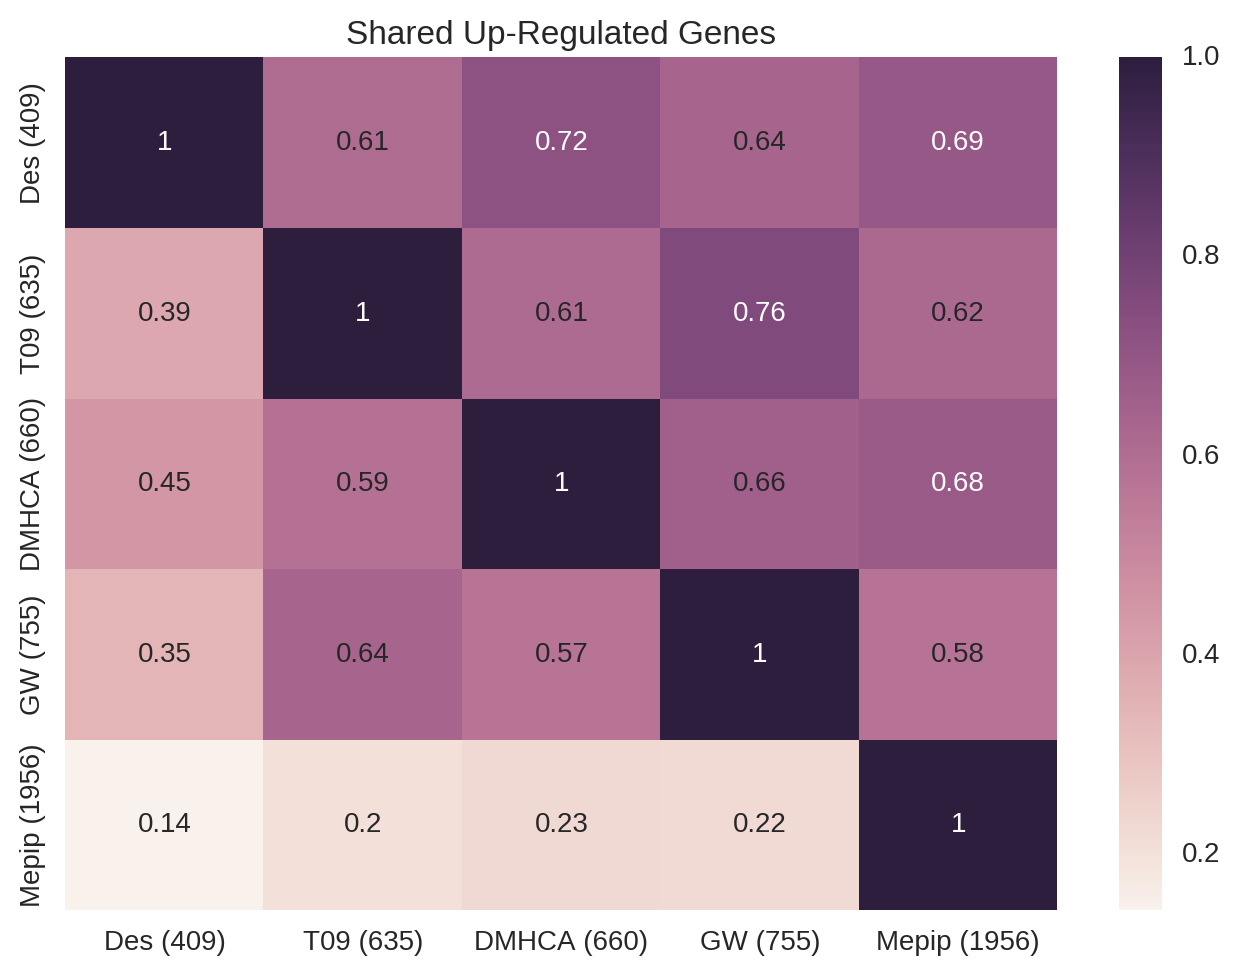

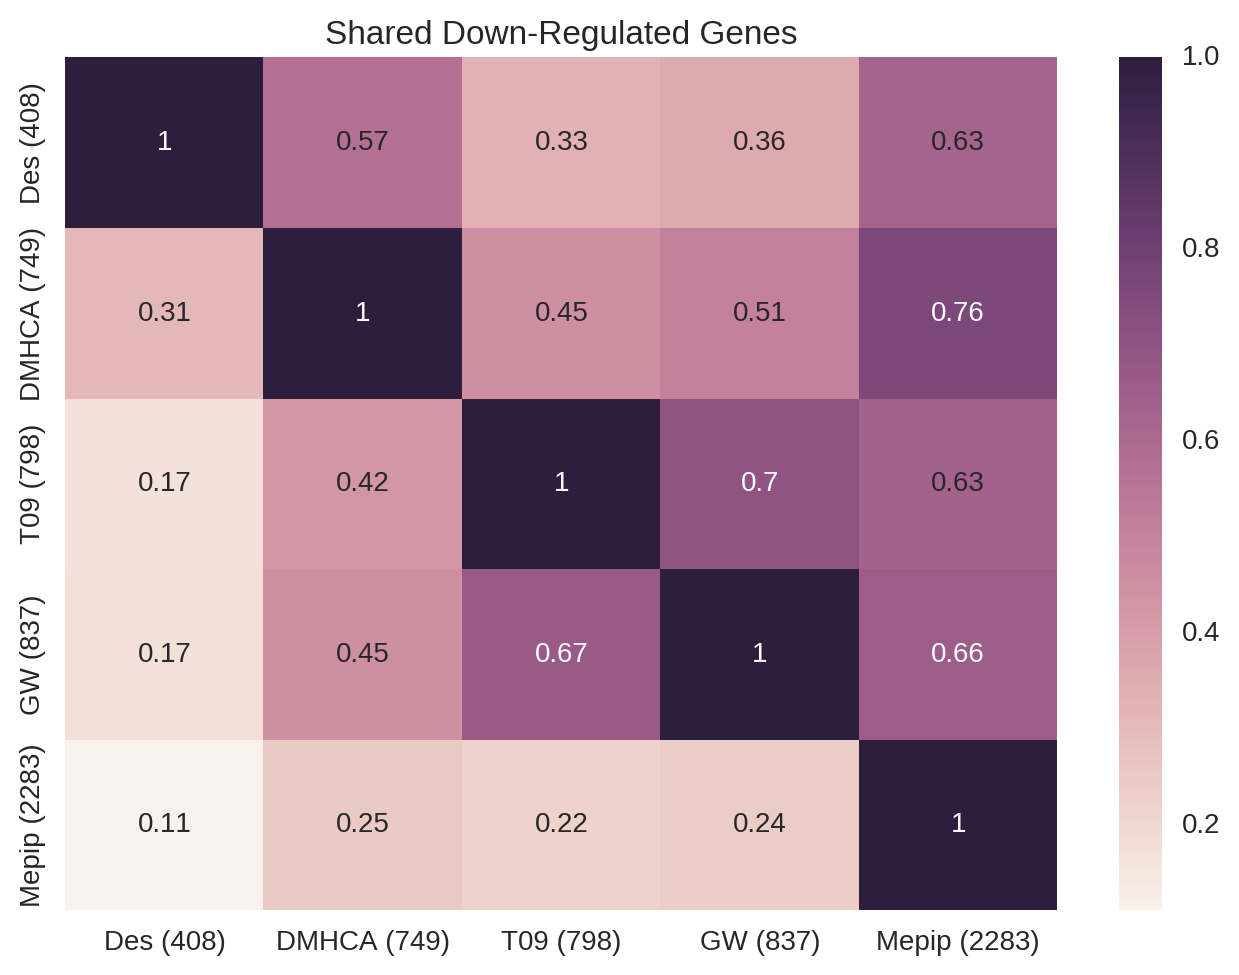

In [37]:
! rm ./diffExpressed_vennDiagrams/*
if not os.path.isdir('./diffExpressed_vennDiagrams'):
    os.mkdir('./diffExpressed_vennDiagrams')
    
# get up and down regulated genes versus vehicle for each condition
# create heat map visualization for how many differentially expressed genes are shared
treatments = sorted(treatment_up_dict.keys())

treatments_up = [x[0] for x in sorted(tuple(zip(treatments, 
                                                [len(treatment_up_dict[x]) for x in treatments])), 
                                      key=lambda x: x[1])]
treatments_down = [x[0] for x in sorted(tuple(zip(treatments, 
                                                [len(treatment_down_dict[x]) for x in treatments])), 
                                      key=lambda x: x[1])]

treatment_up_index_dict = dict(zip(treatments_up , range(len(treatments))))

treatment_down_index_dict = dict(zip(treatments_down , range(len(treatments))))
  
up_matrix = np.zeros((len(treatments), len(treatments)))
down_matrix = np.zeros((len(treatments), len(treatments)))

for i in range(len(treatments) - 1):
    for j in range(i+1, len(treatments)):
        treatment1 = treatments[i]
        treatment2 = treatments[j]
        
        ind1_up = treatment_up_index_dict[treatment1]
        ind2_up = treatment_up_index_dict[treatment2]
        ind1_down = treatment_down_index_dict[treatment1]
        ind2_down =treatment_down_index_dict[treatment2]
        
        num_intersecting_up = len(set(treatment_up_dict[treatment1]).intersection(set(treatment_up_dict[treatment2])))
        num_intersecting_down = len(set(treatment_down_dict[treatment1]).intersection(set(treatment_down_dict[treatment2])))
        up_matrix[ind1_up][ind2_up] = num_intersecting_up
        up_matrix[ind2_up][ind1_up] = num_intersecting_up
        down_matrix[ind1_down][ind2_down] = num_intersecting_down
        down_matrix[ind2_down][ind1_down] = num_intersecting_down

# fill in diagonals
for i in range(len(treatments)):
        treatment = treatments[i]
        ind_up = treatment_up_index_dict[treatment]
        ind_down = treatment_down_index_dict[treatment]
        num_up = len(set(treatment_up_dict[treatment]))
        num_down = len(set(treatment_down_dict[treatment]))
        up_matrix[ind_up][ind_up] = num_up
        down_matrix[ind_down][ind_down] = num_down


up_labels = [x + ' (' +str(len(treatment_up_dict[x])) + ')' for x in treatments_up]
down_labels = [x + ' (' +str(len(treatment_down_dict[x])) + ')' for x in treatments_down]


# convert matrices to data frames
up_frame = pd.DataFrame(up_matrix).astype(int)
up_frame.columns = up_labels
up_frame.index = up_labels

down_frame = pd.DataFrame(down_matrix).astype(int)
down_frame.columns = down_labels
down_frame.index = down_labels

up_frame = up_frame.div(up_frame.max(axis=1), axis=0)
down_frame = down_frame.div(down_frame.max(axis=1), axis=0)

sns.heatmap(up_frame, annot=True)
plt.title("Shared Up-Regulated Genes")
plt.savefig('diffExpressed_vennDiagrams/diffExpressed_matrix_up.png')
plt.show()

sns.heatmap(down_frame, annot=True)
plt.title("Shared Down-Regulated Genes")
plt.savefig('diffExpressed_vennDiagrams/diffExpressed_matrix_down.png')
plt.show()

In [38]:
### make Venn Diagrams
if not os.path.isdir('./diffExpressed_vennDiagrams'):
    os.mkdir('./diffExpressed_vennDiagrams')
treatments = sorted(treatment_up_dict.keys())
for i in range(len(treatments) - 1):
    for j in range(i+1, len(treatments)):
        treatment1 = treatments[i]
        treatment2 = treatments[j]

        up_1 = set(treatment_up_dict[treatment1])
        up_2 = set(treatment_up_dict[treatment2])
        
        down_1 = set(treatment_down_dict[treatment1])
        down_2 = set(treatment_down_dict[treatment2])
        
        venn2([up_1, up_2], set_labels=[treatment1, treatment2])
        plt.savefig('./diffExpressed_vennDiagrams/' + treatment1 + '_' + treatment2 + '_up_vs_veh_venn.png')
        plt.close()
        
        venn2([down_1, down_2], set_labels=[treatment1, treatment2])
        plt.savefig('./diffExpressed_vennDiagrams/' + treatment1 + '_' + treatment2 + '_down_vs_veh_venn.png')
        plt.close()

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib_venn-0.9-py3.4.egg/matplotlib_venn/_venn3.py:422: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


## Gene Ontology Enrichment

In [39]:
outFile = open('./gene_ontology/background.txt', 'w')
for g in raw_frame[raw_frame.ix[:,9:].sum(axis=1) > 16.0]['gene'].values:
    outFile.write(g.upper() + '\n')
outFile.close()

for f in os.listdir('./gene_ontology/'):
    if not 'background' in f and not 'result' in f:
        out_name = f.replace('.txt', '_result.txt')
#         os.system('/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/' 
#                   + f +' ./gene_ontology/background.txt /home/jenhan/analysis/go_analysis/mouse_association --pval=0.05 > ./gene_ontology/' + out_name)
        print('/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/' 
                  + f +' ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/' + out_name + ' &')




/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/DMHCA_up.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/DMHCA_up_result.txt &
/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/Mepip_up.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/Mepip_up_result.txt &
/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/T09_down.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/T09_down_result.txt &
/bioinformatics/software/anaconda2.7/bin/python2 /home/jenhan/code/go_enrichment_scripts/find_enrichment.py ./gene_ontology/Mepip_down.txt ./gene_ontology/background.txt mouse_association --pval=0.05 > ./gene_ontology/Mepip_down_result.txt &
/bioinformatics/software/anaconda2.7/bin/pyt

In [114]:
fdr_threshold = 0.05
p_threshold = 0.05
term_tuples = []
terms = []
treatments = []
for f in os.listdir('./gene_ontology/'):
#     if 'result' in f and 'up' in f and not 'mepip' in f.lower():
    if 'result' in f and 'up' in f :
        with open('./gene_ontology/' + f) as data:
            data = data.readlines()
        if len(data):
            results = pd.read_csv('./gene_ontology/' + f ,sep='\t', skiprows=2)
            treatment = f.split('_')[0]
            treatments.append(treatment)
            significant_results = results[results['p_bonferroni'] < p_threshold]

            # seperate enriched and purified results
            enriched_results = significant_results[significant_results['enrichment']=='e']

            purified_results= significant_results[significant_results['enrichment']=='p']
            terms = terms + list(enriched_results['description'].values)
            term_tuples = term_tuples +list(zip(enriched_results['id'].values,
                                                enriched_results['description'].values, 
                                                enriched_results['p_bonferroni'].values, 
                                                [treatment] * significant_results.shape[0]))
            print(treatment, enriched_results.shape)


terms = sorted(list(set(terms)))
treatments=sorted(treatments)
# treatments.remove('1um-Mepip')
term_id_dict = dict(zip([x[1] for x in term_tuples],
                       [x[0] for x in term_tuples]))
term_index_dict = dict(zip(terms, range(len(terms))))

treatment_index_dict = dict(zip(treatments, range(len(treatments))))
counter = 0
matrix = np.ones((len(terms), len(treatments)))
for t in term_tuples:
    matrix[term_index_dict[t[1]]][treatment_index_dict[t[3]]] = t[2]
up_frame = pd.DataFrame(matrix, columns=treatments, index=terms)
up_frame['id'] = [term_id_dict[x] for x in up_frame.index.values]
# cg = sns.clustermap(-1* np.log10(up_frame.ix[:,:-1] + 0.0000001),
#                    col_cluster=False)
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);


# hm = cg.ax_heatmap.get_position()
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=5, rotation=0)
# plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10, rotation=90)


# # cg.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.5, hm.height*2.25])
# # col = cg.ax_row_dendrogram.get_position()
# # cg.ax_row_dendrogram.set_position([col.x0, col.y0, col.width, col.height*2.25])
# plt.savefig('./gene_ontology/significant_terms_up.pdf', bbox_inches='tight')
# sns.set_context('notebook', font_scale=1)
# plt.title('Up-Regulated GO Terms')
# plt.show()

term_tuples = []
terms = []
treatments = []
for f in os.listdir('./gene_ontology/'):
#     if 'result' in f and 'down' in f and not 'mepip' in f.lower():
    if 'result' in f and 'down' in f:
        with open('./gene_ontology/' + f) as data:
            data = data.readlines()
        if len(data):
            results = pd.read_csv('./gene_ontology/' + f ,sep='\t', skiprows=2)
            treatment = f.split('_')[0]
            treatments.append(treatment)
            significant_results = results[results['p_bonferroni'] < p_threshold]

            # seperate enriched and purified results
            enriched_results = significant_results[significant_results['enrichment']=='e']

            purified_results= significant_results[significant_results['enrichment']=='p']
            terms = terms + list(enriched_results['description'].values)
            term_tuples = term_tuples +list(zip(enriched_results['id'].values,
                                                enriched_results['description'].values, 
                                                enriched_results['p_bonferroni'].values, 
                                                [treatment] * significant_results.shape[0]))
            print(treatment, enriched_results.shape)


terms = sorted(list(set(terms)))
treatments=sorted(treatments)
# treatments.remove('1um-Mepip')
term_id_dict = dict(zip([x[1] for x in term_tuples],
                       [x[0] for x in term_tuples]))
term_index_dict = dict(zip(terms, range(len(terms))))

treatment_index_dict = dict(zip(treatments, range(len(treatments))))
counter = 0
matrix = np.ones((len(terms), len(treatments)))
for t in term_tuples:
    matrix[term_index_dict[t[1]]][treatment_index_dict[t[3]]] = t[2]
down_frame = pd.DataFrame(matrix, columns=treatments, index=terms)
down_frame['id'] = [term_id_dict[x] for x in down_frame.index.values]

# cg = sns.clustermap(-1* np.log10(down_frame.ix[:,:-1] + 0.0000001),
#                    col_cluster=False)
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);


# hm = cg.ax_heatmap.get_position()
# plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), fontsize=5, rotation=0)
# plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), fontsize=10, rotation=90)


# cg.ax_heatmap.set_position([hm.x0, hm.y0, hm.width*0.5, hm.height*2.25])
# col = cg.ax_row_dendrogram.get_position()
# cg.ax_row_dendrogram.set_position([col.x0, col.y0, col.width, col.height*2.25])
# plt.savefig('./gene_ontology/significant_terms_down.pdf', bbox_inches='tight')
# sns.set_context('notebook', font_scale=1)
# plt.title('Down-regulated GO Terms')
# plt.show()




# save to text and spreadsheets
# labels = up_frame.index.values
# features = up_frame.ix[:,0:5]
# distances = scipy.spatial.distance.pdist(features)
# linkage = scipy.cluster.hierarchy.linkage(distances, method='complete')
# dendrogram = scipy.cluster.hierarchy.dendrogram(linkage, labels = labels);
# plt.close()
# up_frame = up_frame.ix[dendrogram['ivl'],:]
# labels = down_frame.index.values
# features = down_frame.ix[:,0:5]
# distances = scipy.spatial.distance.pdist(features)
# linkage = scipy.cluster.hierarchy.linkage(distances, method='complete')
# dendrogram = scipy.cluster.hierarchy.dendrogram(linkage, labels = labels);
# plt.close()
# down_frame = down_frame.ix[dendrogram['ivl'],:]

up_frame=up_frame[[x for x in  up_frame.columns if not '30' in x]]
down_frame=down_frame[[x for x in  down_frame.columns if not '30' in x]]

# save go terms
up_frame.to_csv('go_terms_up.tsv', sep='\t')
down_frame.to_csv('go_terms_down.tsv', sep='\t')
out_file = open('go_ids_up.txt', 'w')
for id in up_frame['id'].values:
    out_file.write(id.strip() + '\n')
out_file.close()

out_file = open('go_ids_down.txt', 'w')
for id in down_frame['id'].values:
    out_file.write(id.strip() + '\n')
out_file.close()

T09 (30, 10)
GW (45, 10)
Des (20, 10)
DMHCA (49, 10)
Mepip (122, 10)
DMHCA (178, 10)
Mepip (466, 10)
T09 (204, 10)
Des (42, 10)
GW (214, 10)


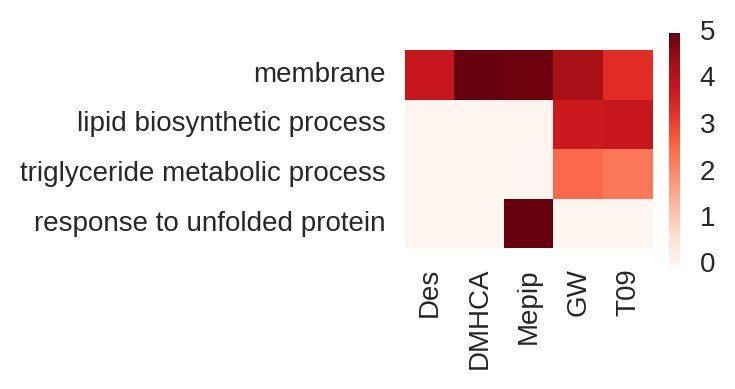

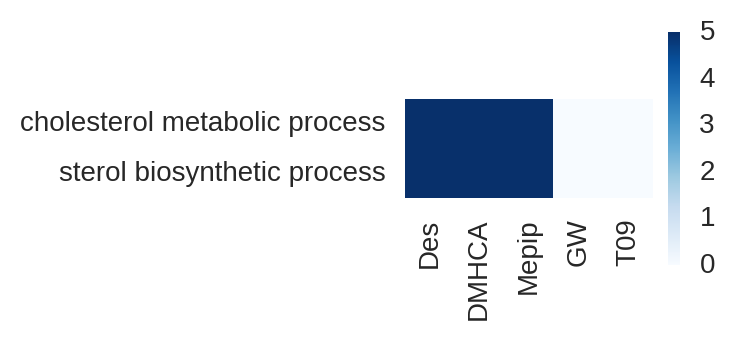

In [117]:
for t in ['membrane',
                'lipid biosynthetic process',
                'triglyceride metabolic process',
                'response to unfolded protein']:
    if not t in up_frame.index.values:
        up_frame = up_frame.T
        up_frame[t]= 1.0
        up_frame = up_frame.T
    

data = pd.DataFrame(up_frame.ix[['membrane',
                'lipid biosynthetic process',
                'triglyceride metabolic process',
                'response to unfolded protein'],
                   ['Des',
                    'DMHCA',
                    'Mepip', 
                    'GW', 
                    'T09']])
data = data.fillna(1)
plt.figure(figsize=(2,1.5))
with sns.axes_style('whitegrid'):
    sns.heatmap(-1*np.log10(data.astype(float)), 
                cmap='Reds',
                square=True,
               vmax=5)
plt.savefig('./gene_ontology/significant_terms_up.pdf', bbox_inches='tight')
plt.show()

for t in ['cholesterol metabolic process',
                'sterol biosynthetic process',
                       ]:
    if not t in down_frame.index.values:
        down_frame = down_frame.T
        down_frame[t]= 1.0
        down_frame = down_frame.T
        
        
data = down_frame.ix[['cholesterol metabolic process',
                'sterol biosynthetic process',
                       ],
                     ['Des',
                    'DMHCA',
                    'Mepip', 
                    'GW', 
                    'T09']]
data = data.fillna(1)

plt.figure(figsize=(2,1.5))
with sns.axes_style('whitegrid'):
    sns.heatmap(-1*np.log10(data.astype(float)), 
                cmap='Blues',
                square=True,
               vmax=5)
plt.savefig('./gene_ontology/significant_terms_down.pdf', bbox_inches='tight')






## Bar Plots

## Tag Scatter Plots

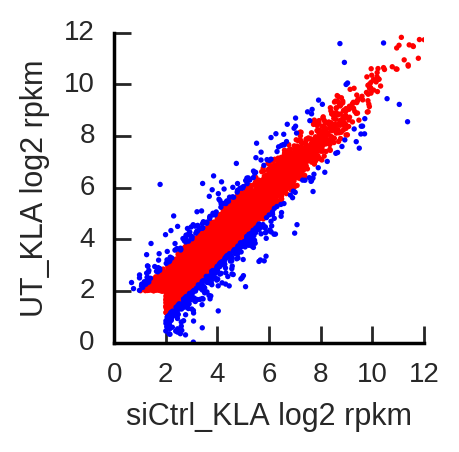

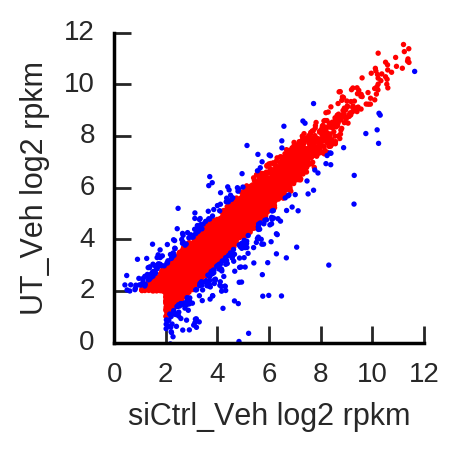

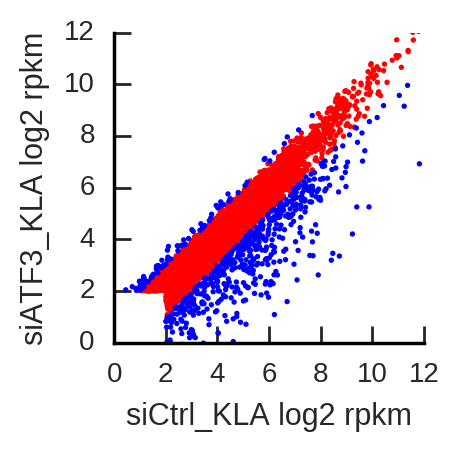

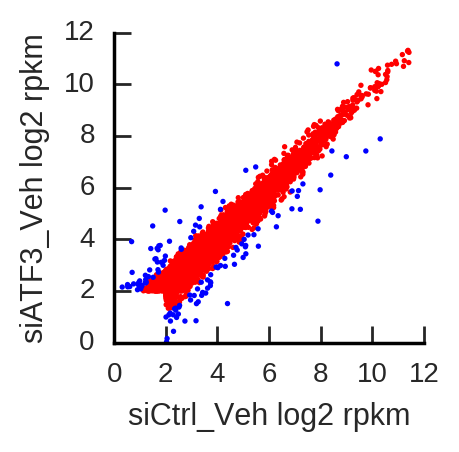

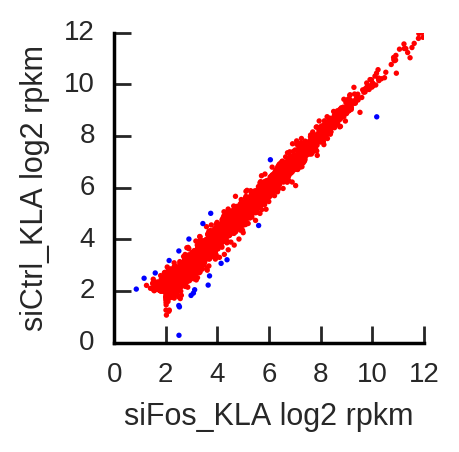

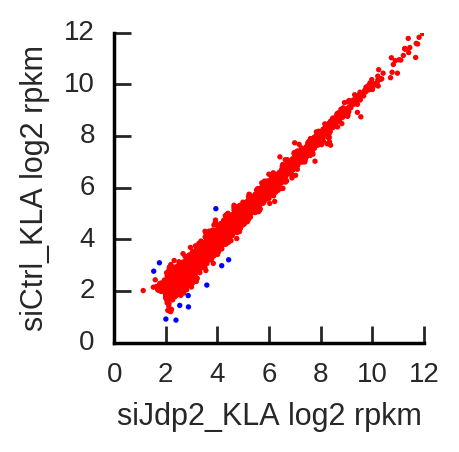

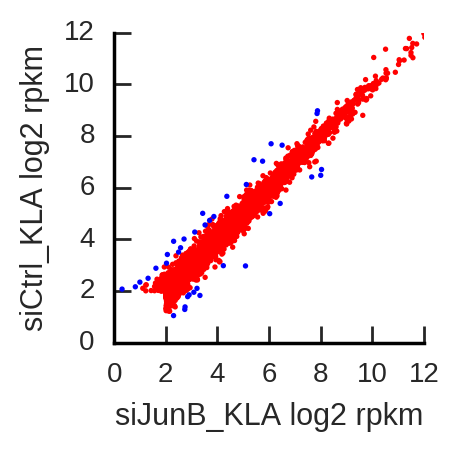

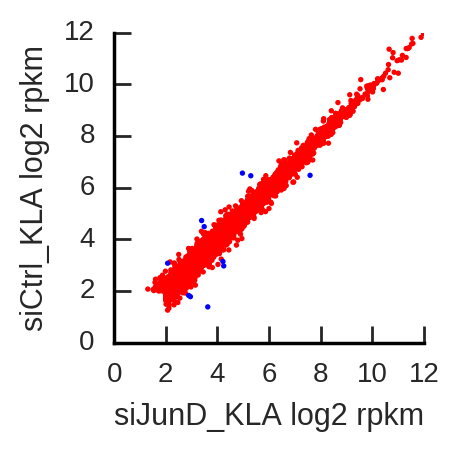

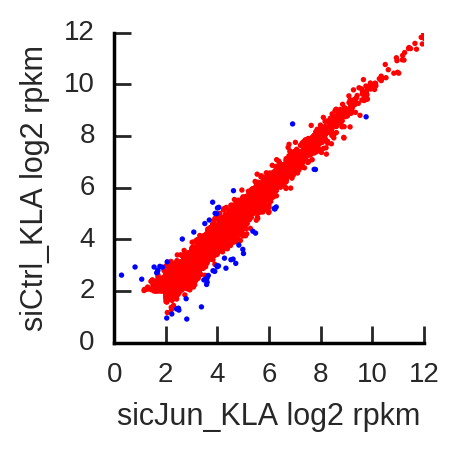

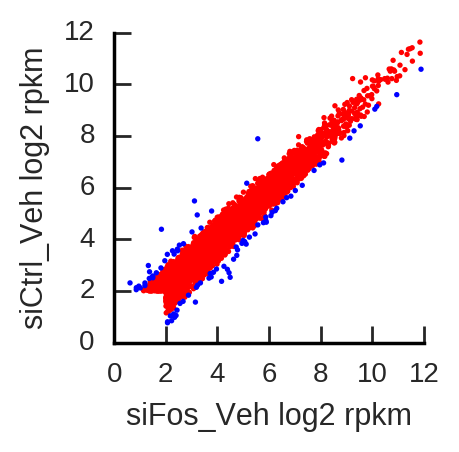

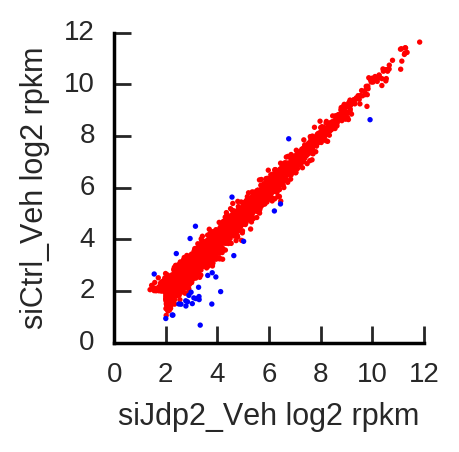

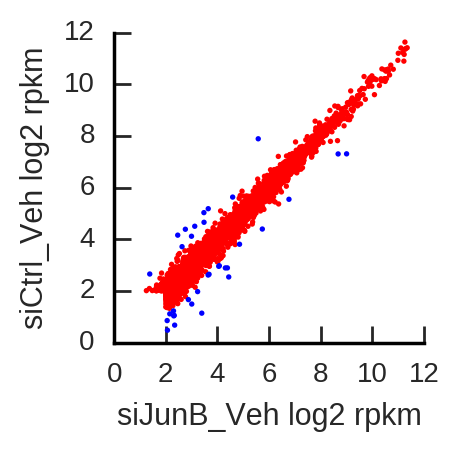

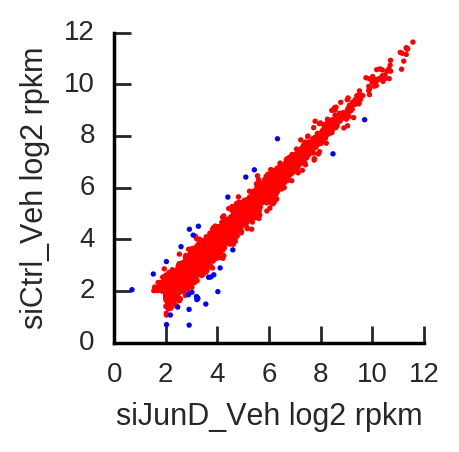

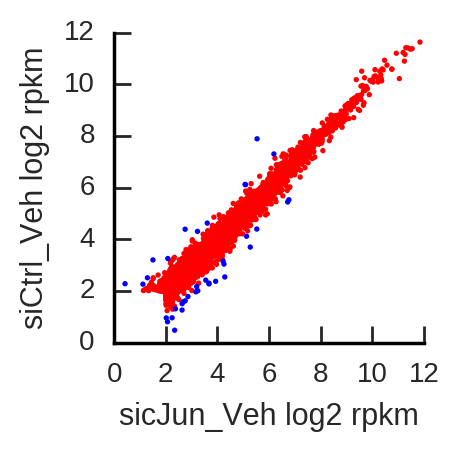

In [189]:
sns.set_style('ticks',{'axes.edgecolor': 'black',
                       'xtick.direction': 'in',
                       'ytick.direction': 'in', 
                         })

! rm ./scatter_plots/*


if not os.path.isdir('./scatter_plots'):
    os.mkdir('./scatter_plots/')
treatment_up_dict = {}
treatment_down_dict = {}
   
fdr_threshold = 0.05
fold_threshold = 2
rpkm_cutoff = 4.0
   
fdrColumns = [x for x in diffExpression_frame.columns if 'adj.' in x]


for c in fdrColumns:
    
    tokens = c.split()
    if 'Ctrl' in tokens[0].lower():
        treatment1 = tokens[0]
        treatment2 = tokens[2]
    else:
        treatment1 = tokens[2]
        treatment2 = tokens[0]
    if not ('Veh' in c and 'KLA' in c) and 'Ctrl' in c:
        reads1 = idr_rpkm_mean_frame[treatment1]
        reads2 = idr_rpkm_mean_frame[treatment2]

        all_genes = idr_rpkm_mean_frame.index.values
        read_tuple_list = tuple(zip(all_genes, reads1, reads2))
        filtered_read_tuple_list = [x for x in read_tuple_list if x[1] >= rpkm_cutoff or x[2]>= rpkm_cutoff ]

        filtered_genes = [x[0] for x in filtered_read_tuple_list]
        reads1 = np.array([x[1] for x in filtered_read_tuple_list])
        reads2 = np.array([x[2] for x in filtered_read_tuple_list])

        fold_genes = []
        for i in range(len(filtered_genes)): 
            fold = (reads1[i]+0.01)/(reads2[i]+0.01)
            if fold >=fold_threshold or fold <=1/fold_threshold:
                fold_genes.append(filtered_genes[i])

        colors = ['blue' if x in fold_genes else 'red' for x in filtered_genes]


        # log values
        reads1 = np.log2(reads1 + 0.0000001)
        reads2 = np.log2(reads2 + 0.0000001)

        # ensure diff diff expressed genes are on top
        val_tuples = tuple(zip(reads1,reads2,colors))
        sorted_tuples = sorted(val_tuples,key=lambda x: x[2], reverse=True)
        reads1 = [x[0] for x in sorted_tuples] 
        reads2 = [x[1] for x in sorted_tuples]
        colors = [x[2] for x in sorted_tuples]
        plt.figure(figsize=(2,2))
        plt.scatter(reads1, reads2, edgecolors='none', c=colors, marker = '.', s=15)
        sns.despine()
        # fix aspect ratio
        ax = plt.gca()
        ax.set_xlim((0,12))
        ax.set_ylim((0,12))
        x0,x1 = ax.get_xlim()
        y0,y1 = ax.get_ylim()
        ax.set_aspect(abs(x1-x0)/abs(y1-y0))        
        plt.xlabel(treatment1 + ' log2 rpkm')
        plt.ylabel(treatment2 + ' log2 rpkm')
        plt.savefig('./scatter_plots/'+ treatment1 + '_' + treatment2 + '_logRPKM_scatter.pdf', bbox_inches='tight')
        plt.show()

        

## PCA Analysis

In [ ]:
from matplotlib import patches as mpatches

num down 967 num up 290


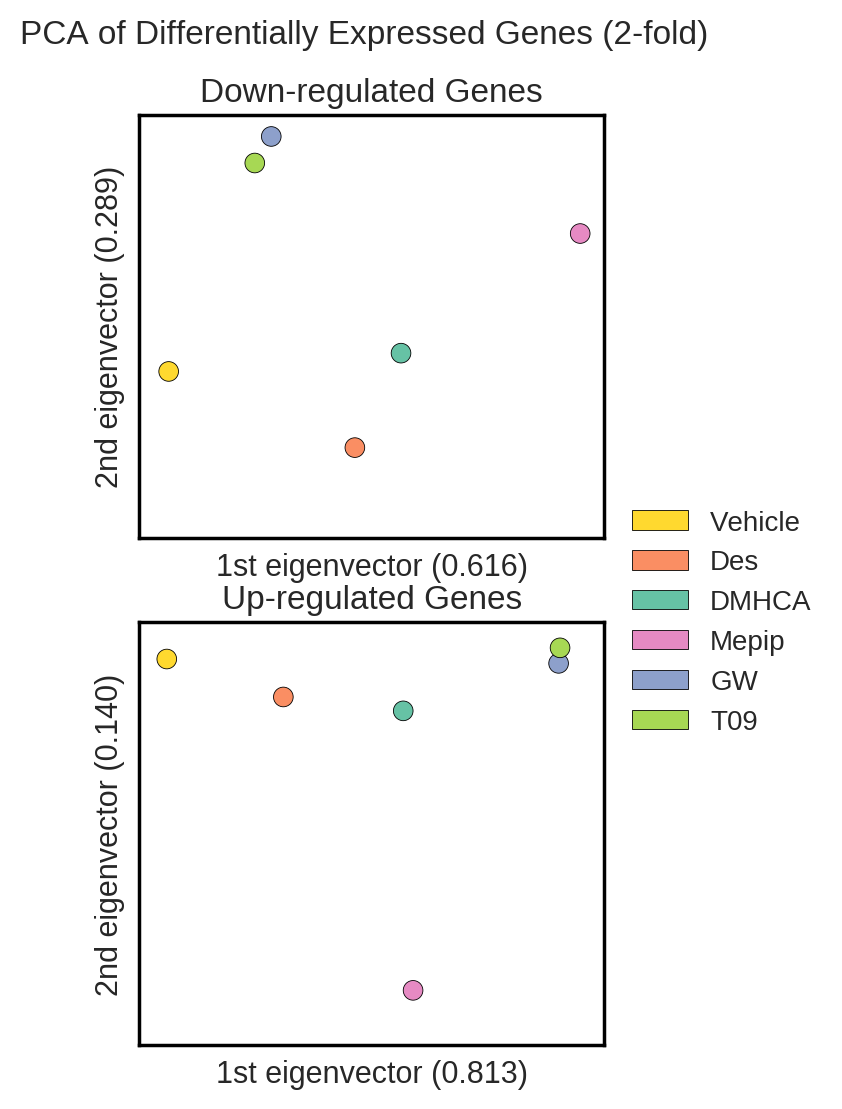

In [118]:
### for up-regulated genes
from matplotlib import patches as mpatches

colorDict = dict(zip(sorted(set(filtered_summary_frame['simpleTreatment'].values)), 
                 sns.color_palette("Set2") + sns.color_palette("colorblind")))

fdr_threshold = 0.05
fold_threshold = np.log2(2)
fdr_cols = [x for x in diffExpression_frame.columns if 'FDR' in x and 'vs. Vehicle' in x]
fold_cols = [x for x in diffExpression_frame.columns if 'logFC' in x and 'vs. Vehicle' in x]

down_diff_genes = diffExpression_frame[(diffExpression_frame[fdr_cols].min(axis=1) < fdr_threshold) &
                                  (diffExpression_frame[fold_cols].max(axis=1) >= fold_threshold)
                                 ]['gene'].values
down_diff_genes = [x.upper() for x in down_diff_genes]

up_diff_genes = diffExpression_frame[(diffExpression_frame[fdr_cols].min(axis=1) < fdr_threshold) &
                                  (diffExpression_frame[fold_cols].min(axis=1) <= -1*fold_threshold)
                                 ]['gene'].values
up_diff_genes = [x.upper() for x in up_diff_genes]

print('num down', len(down_diff_genes), 'num up', len(up_diff_genes))
f, axs = plt.subplots(2,1, figsize=(3,6))
plt.suptitle('PCA of Differentially Expressed Genes (2-fold)')

### down_regulated genes
features = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(down_diff_genes)]
colors = [colorDict[x] for x in features.columns.values]

down_model = sklearn.decomposition.PCA(n_components=2)
reduced_features = down_model.fit_transform(features.T)
explained_variance_ratios = down_model.explained_variance_ratio_

plt.subplot(2,1,1)  
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=50)

plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])
plt.title('Down-regulated Genes')

### up-regulatd genes
features = idr_rpkm_mean_frame[idr_rpkm_mean_frame.index.isin(up_diff_genes)]
colors = [colorDict[x] for x in features.columns.values]

up_model = sklearn.decomposition.PCA(n_components=2)
reduced_features = up_model.fit_transform(features.T)
explained_variance_ratios = up_model.explained_variance_ratio_

plt.subplot(2,1,2)  
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, s=50)
plt.xlabel("1st eigenvector (" + "{:.3f}".format(explained_variance_ratios[0]) +')')
plt.xticks([])
plt.ylabel("2nd eigenvector (" + "{:.3f}".format(explained_variance_ratios[1]) +')')
plt.yticks([])
plt.title('Up-regulated Genes')

# legend
classes = ['Vehicle', 'Des', 'DMHCA', 'Mepip','GW', 'T09']

classes = [x for x in classes if not '30' in x]
class_colours = [colorDict[x] for x in classes]
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc='right', bbox_to_anchor=(1.5, 1.0))

plt.savefig('pca_2fold.pdf',bbox_inches='tight')
plt.show()

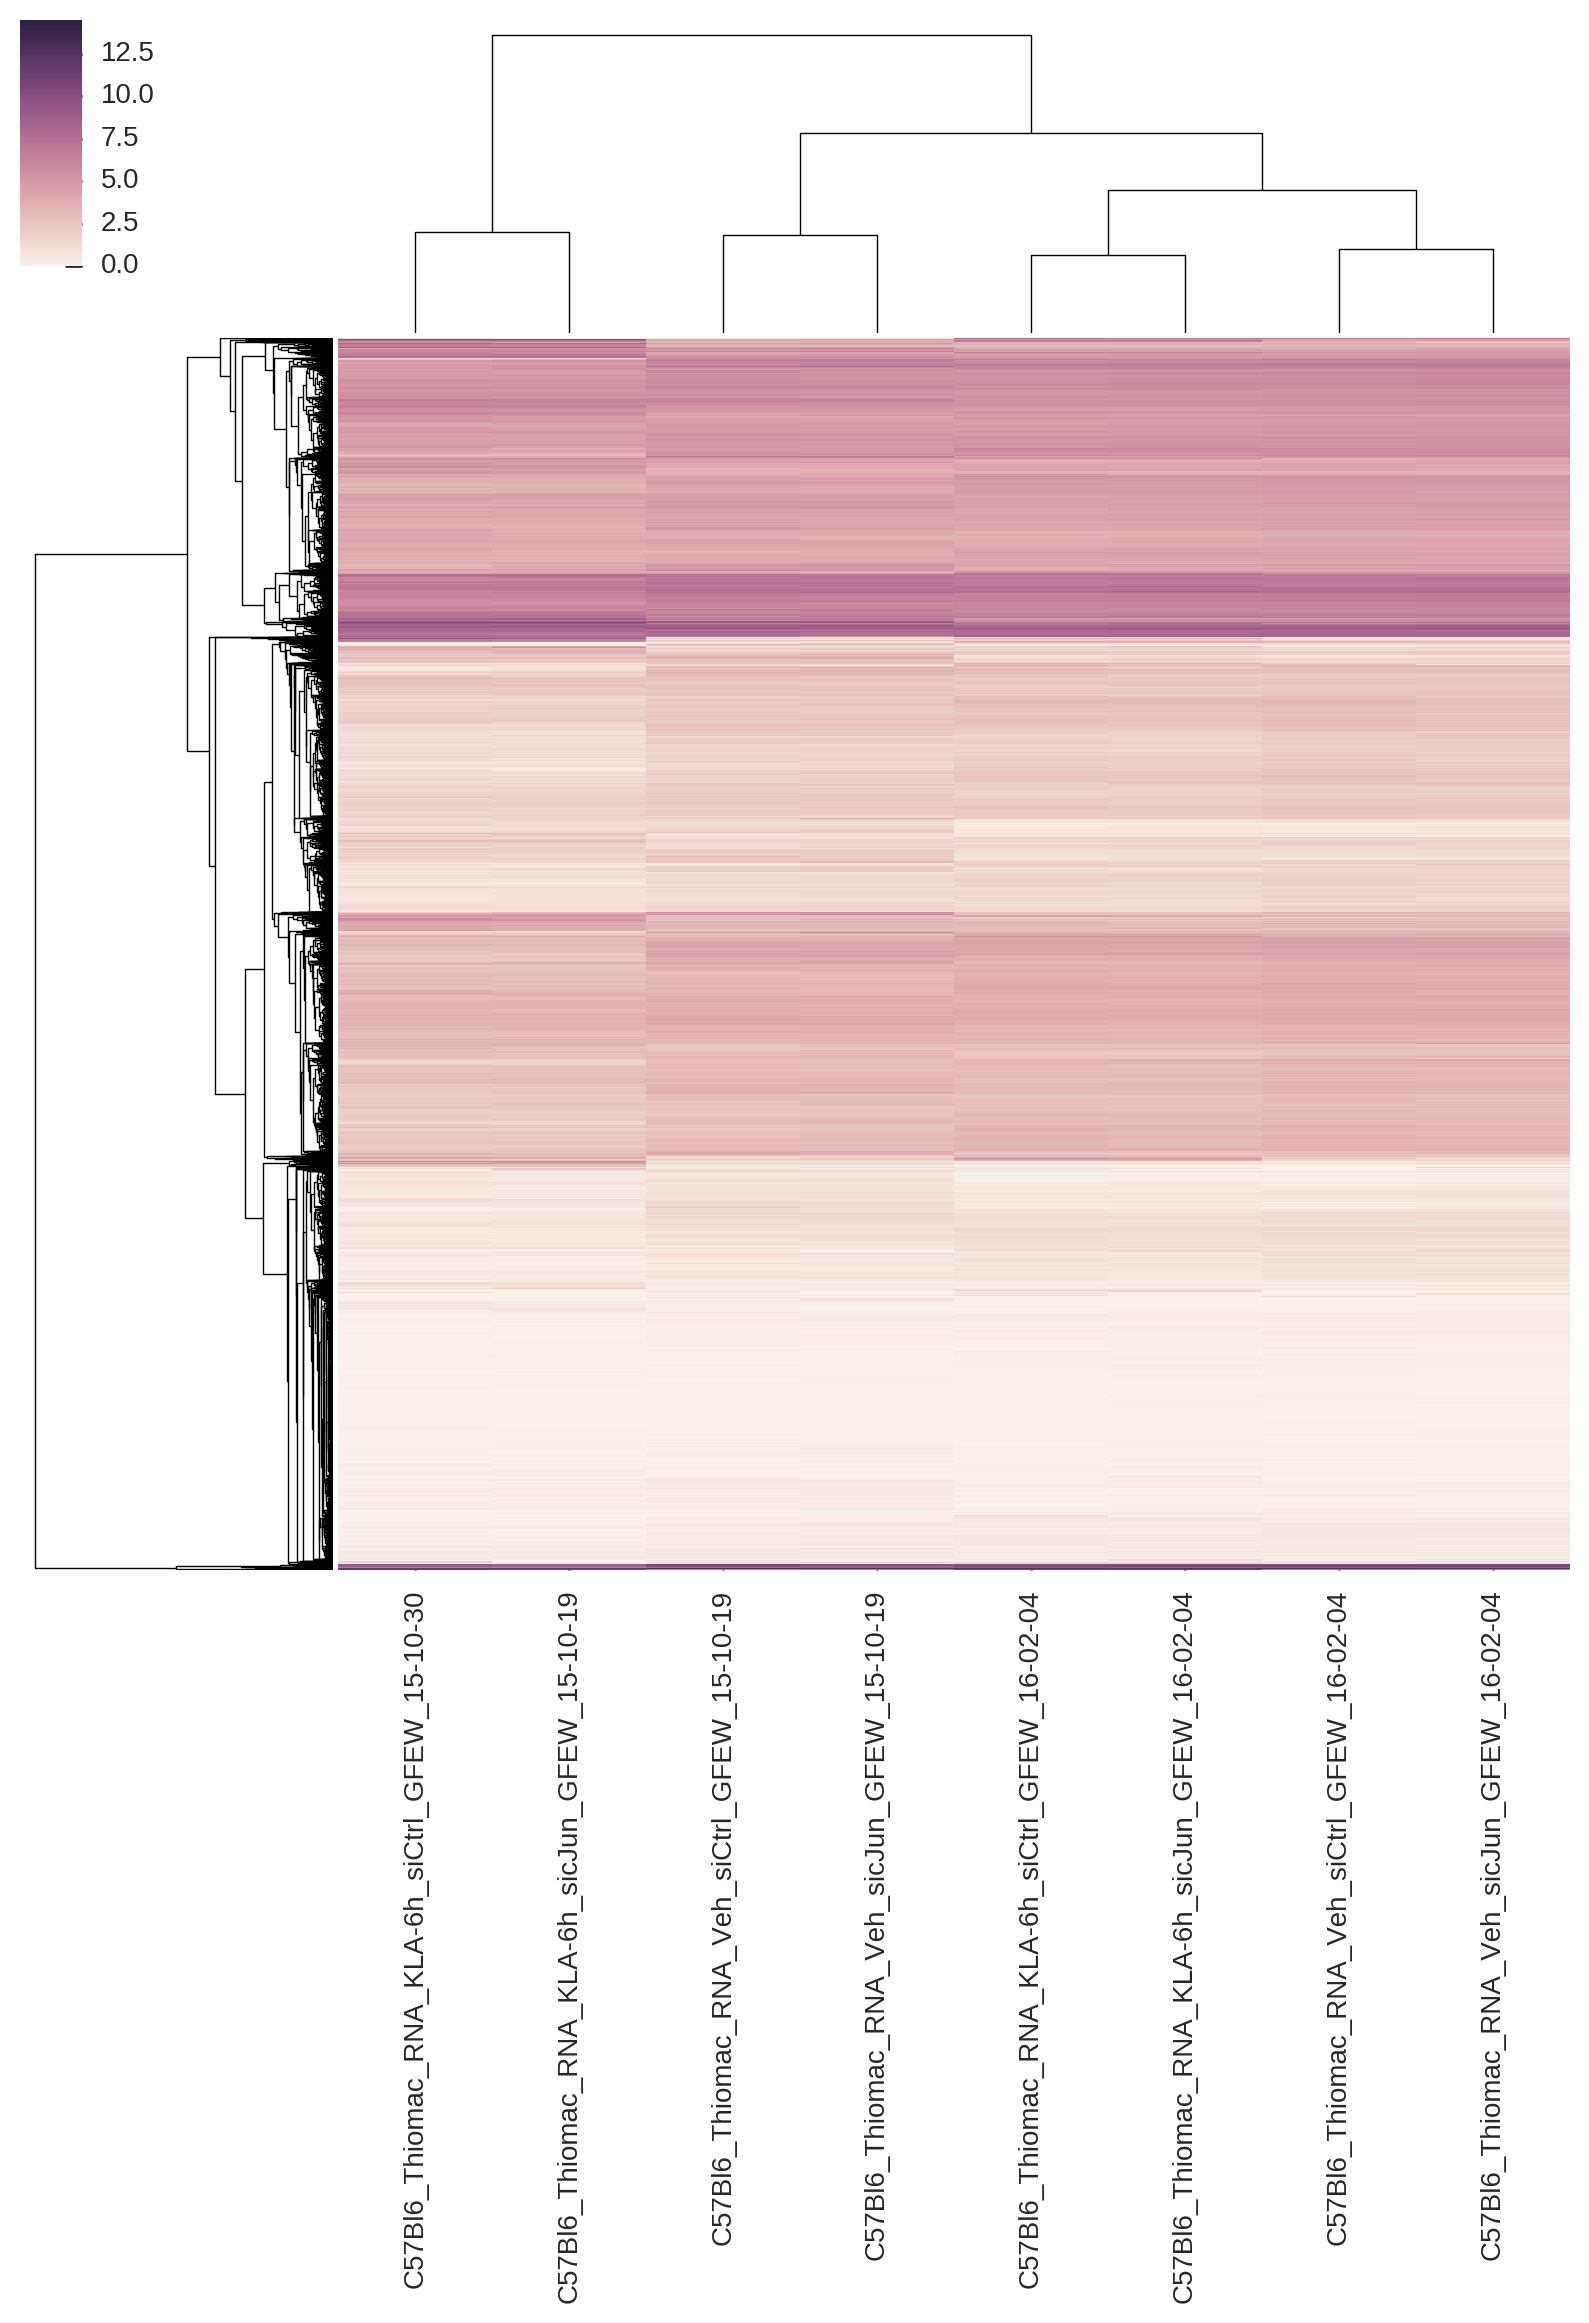

In [221]:
sns.clustermap(np.log2(filtered_rpkm_frame[[x for x in filtered_rpkm_frame.columns.values if 'sicJun' in x or 'siCtrl' in x]] +1),
               yticklabels=False)

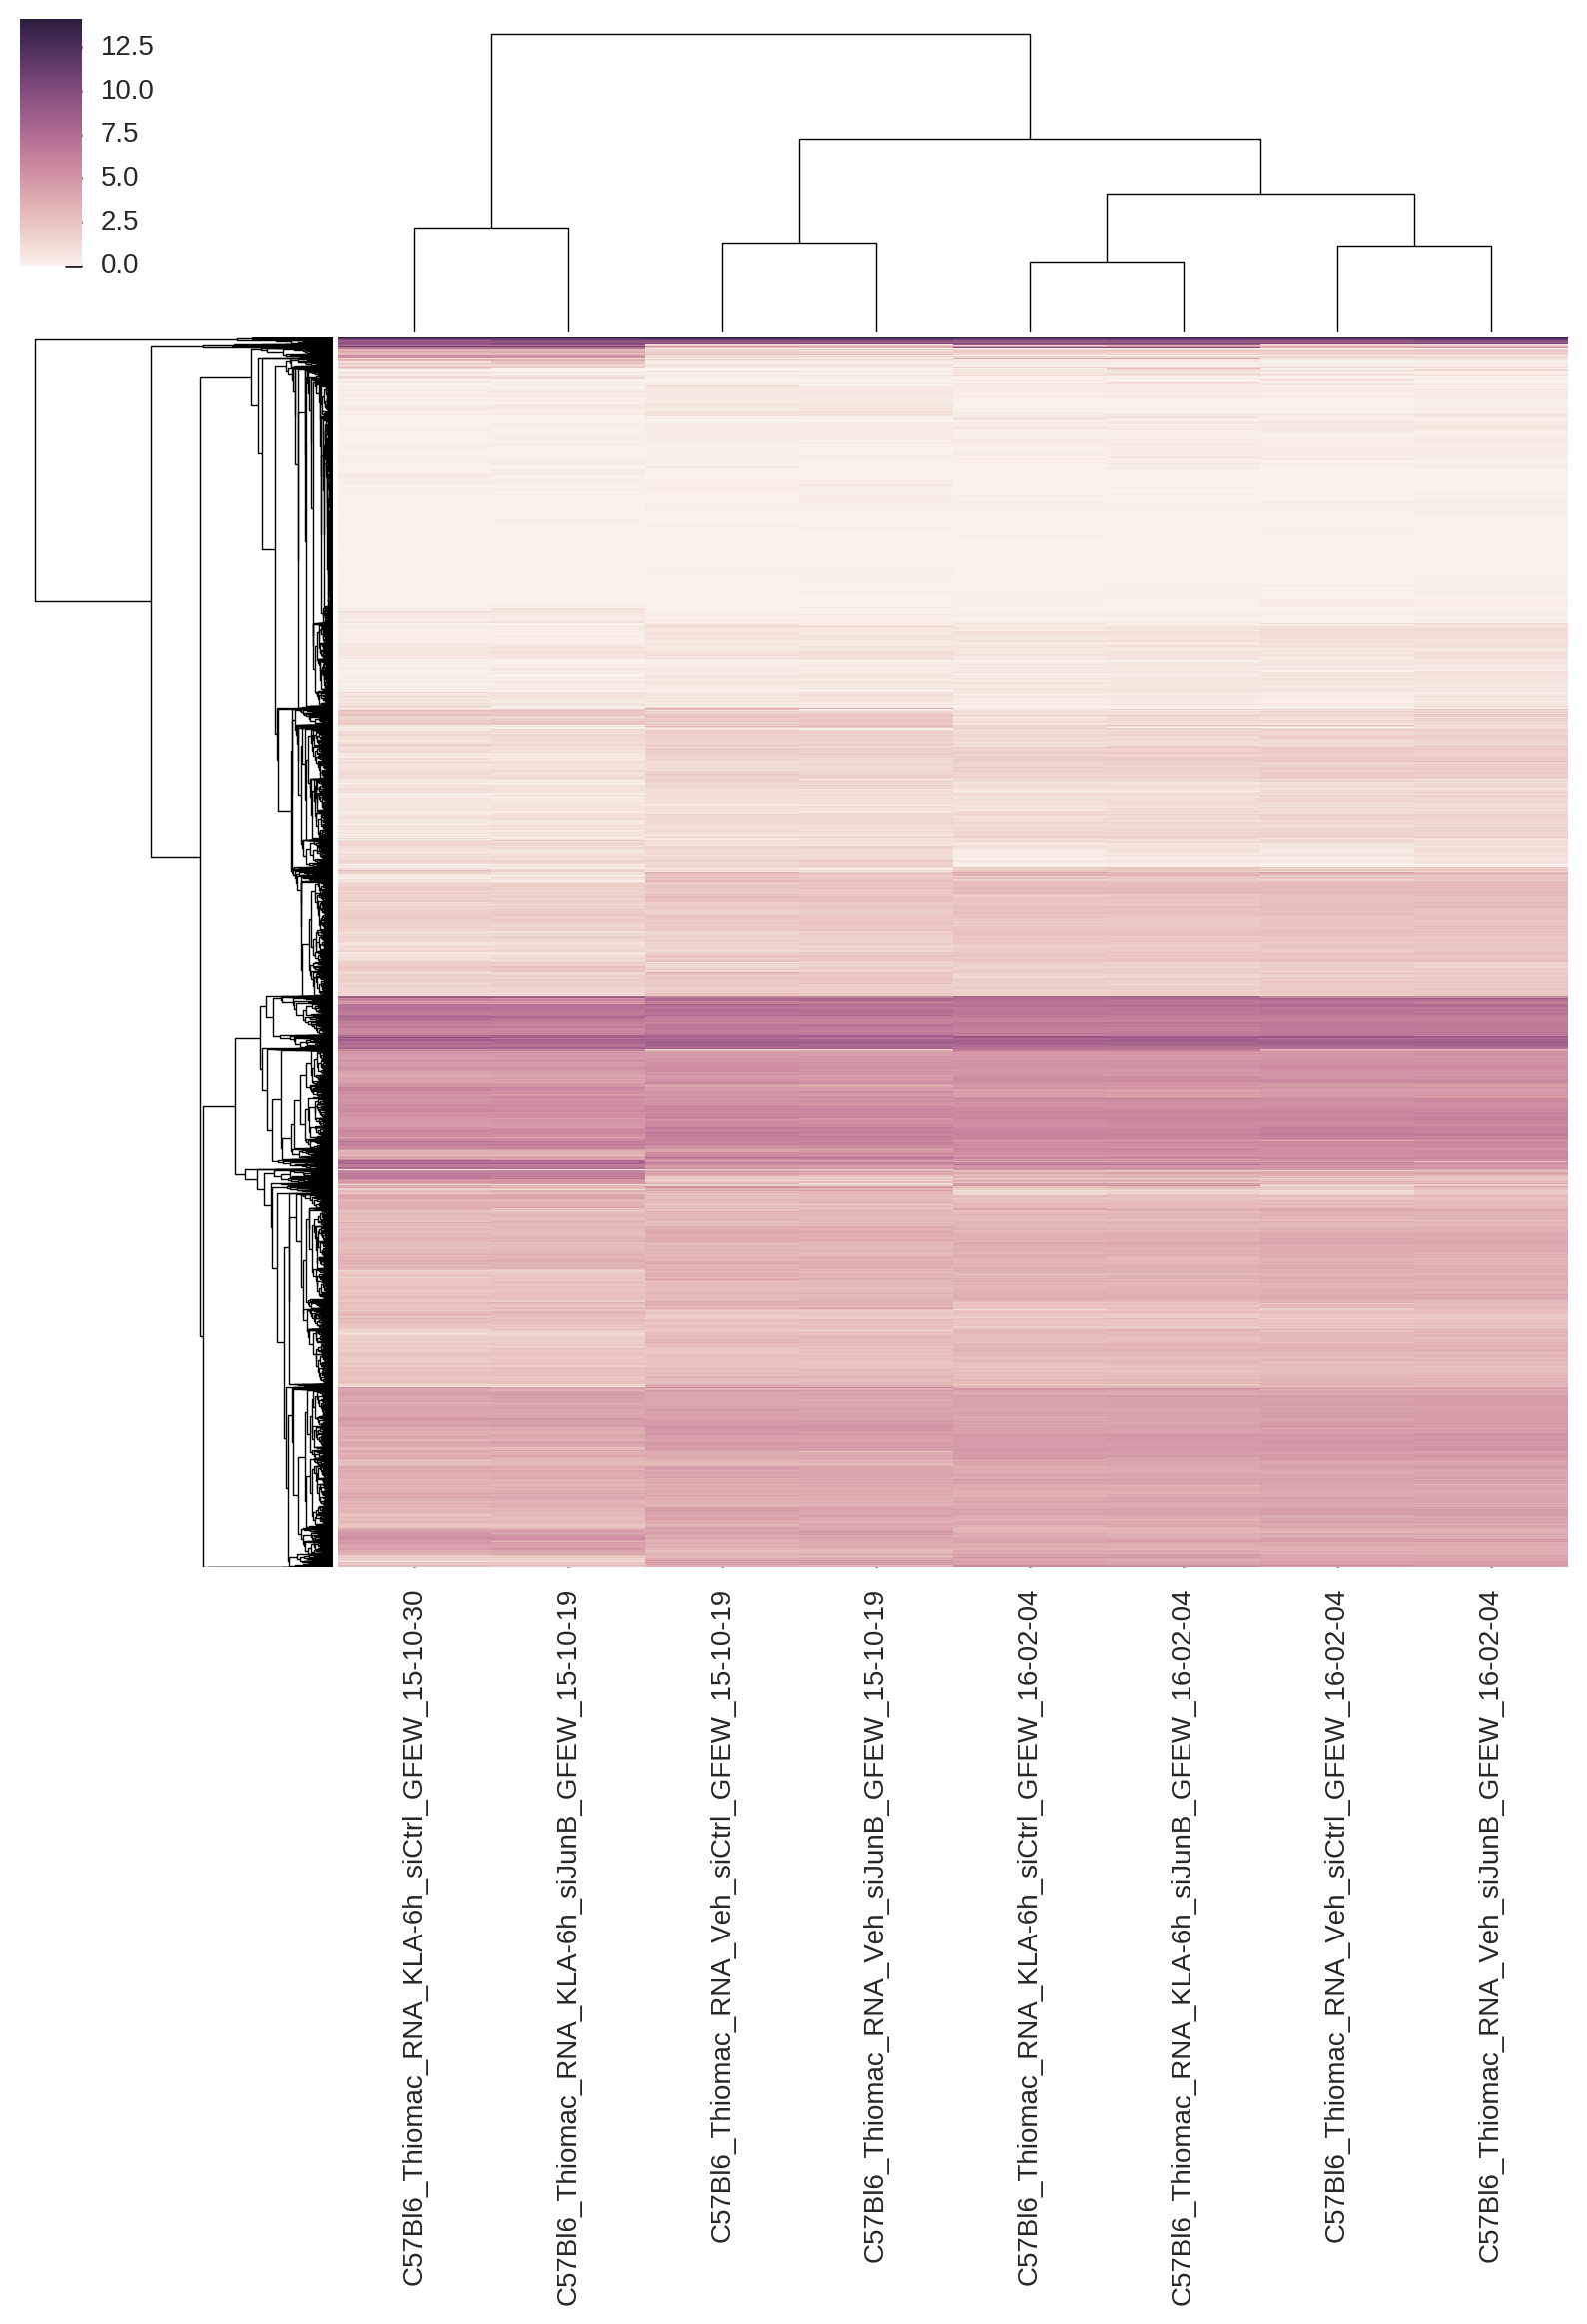

In [222]:
sns.clustermap(np.log2(filtered_rpkm_frame[[x for x in filtered_rpkm_frame.columns.values if 'siJunB' in x or 'siCtrl' in x]] +1),
               yticklabels=False)

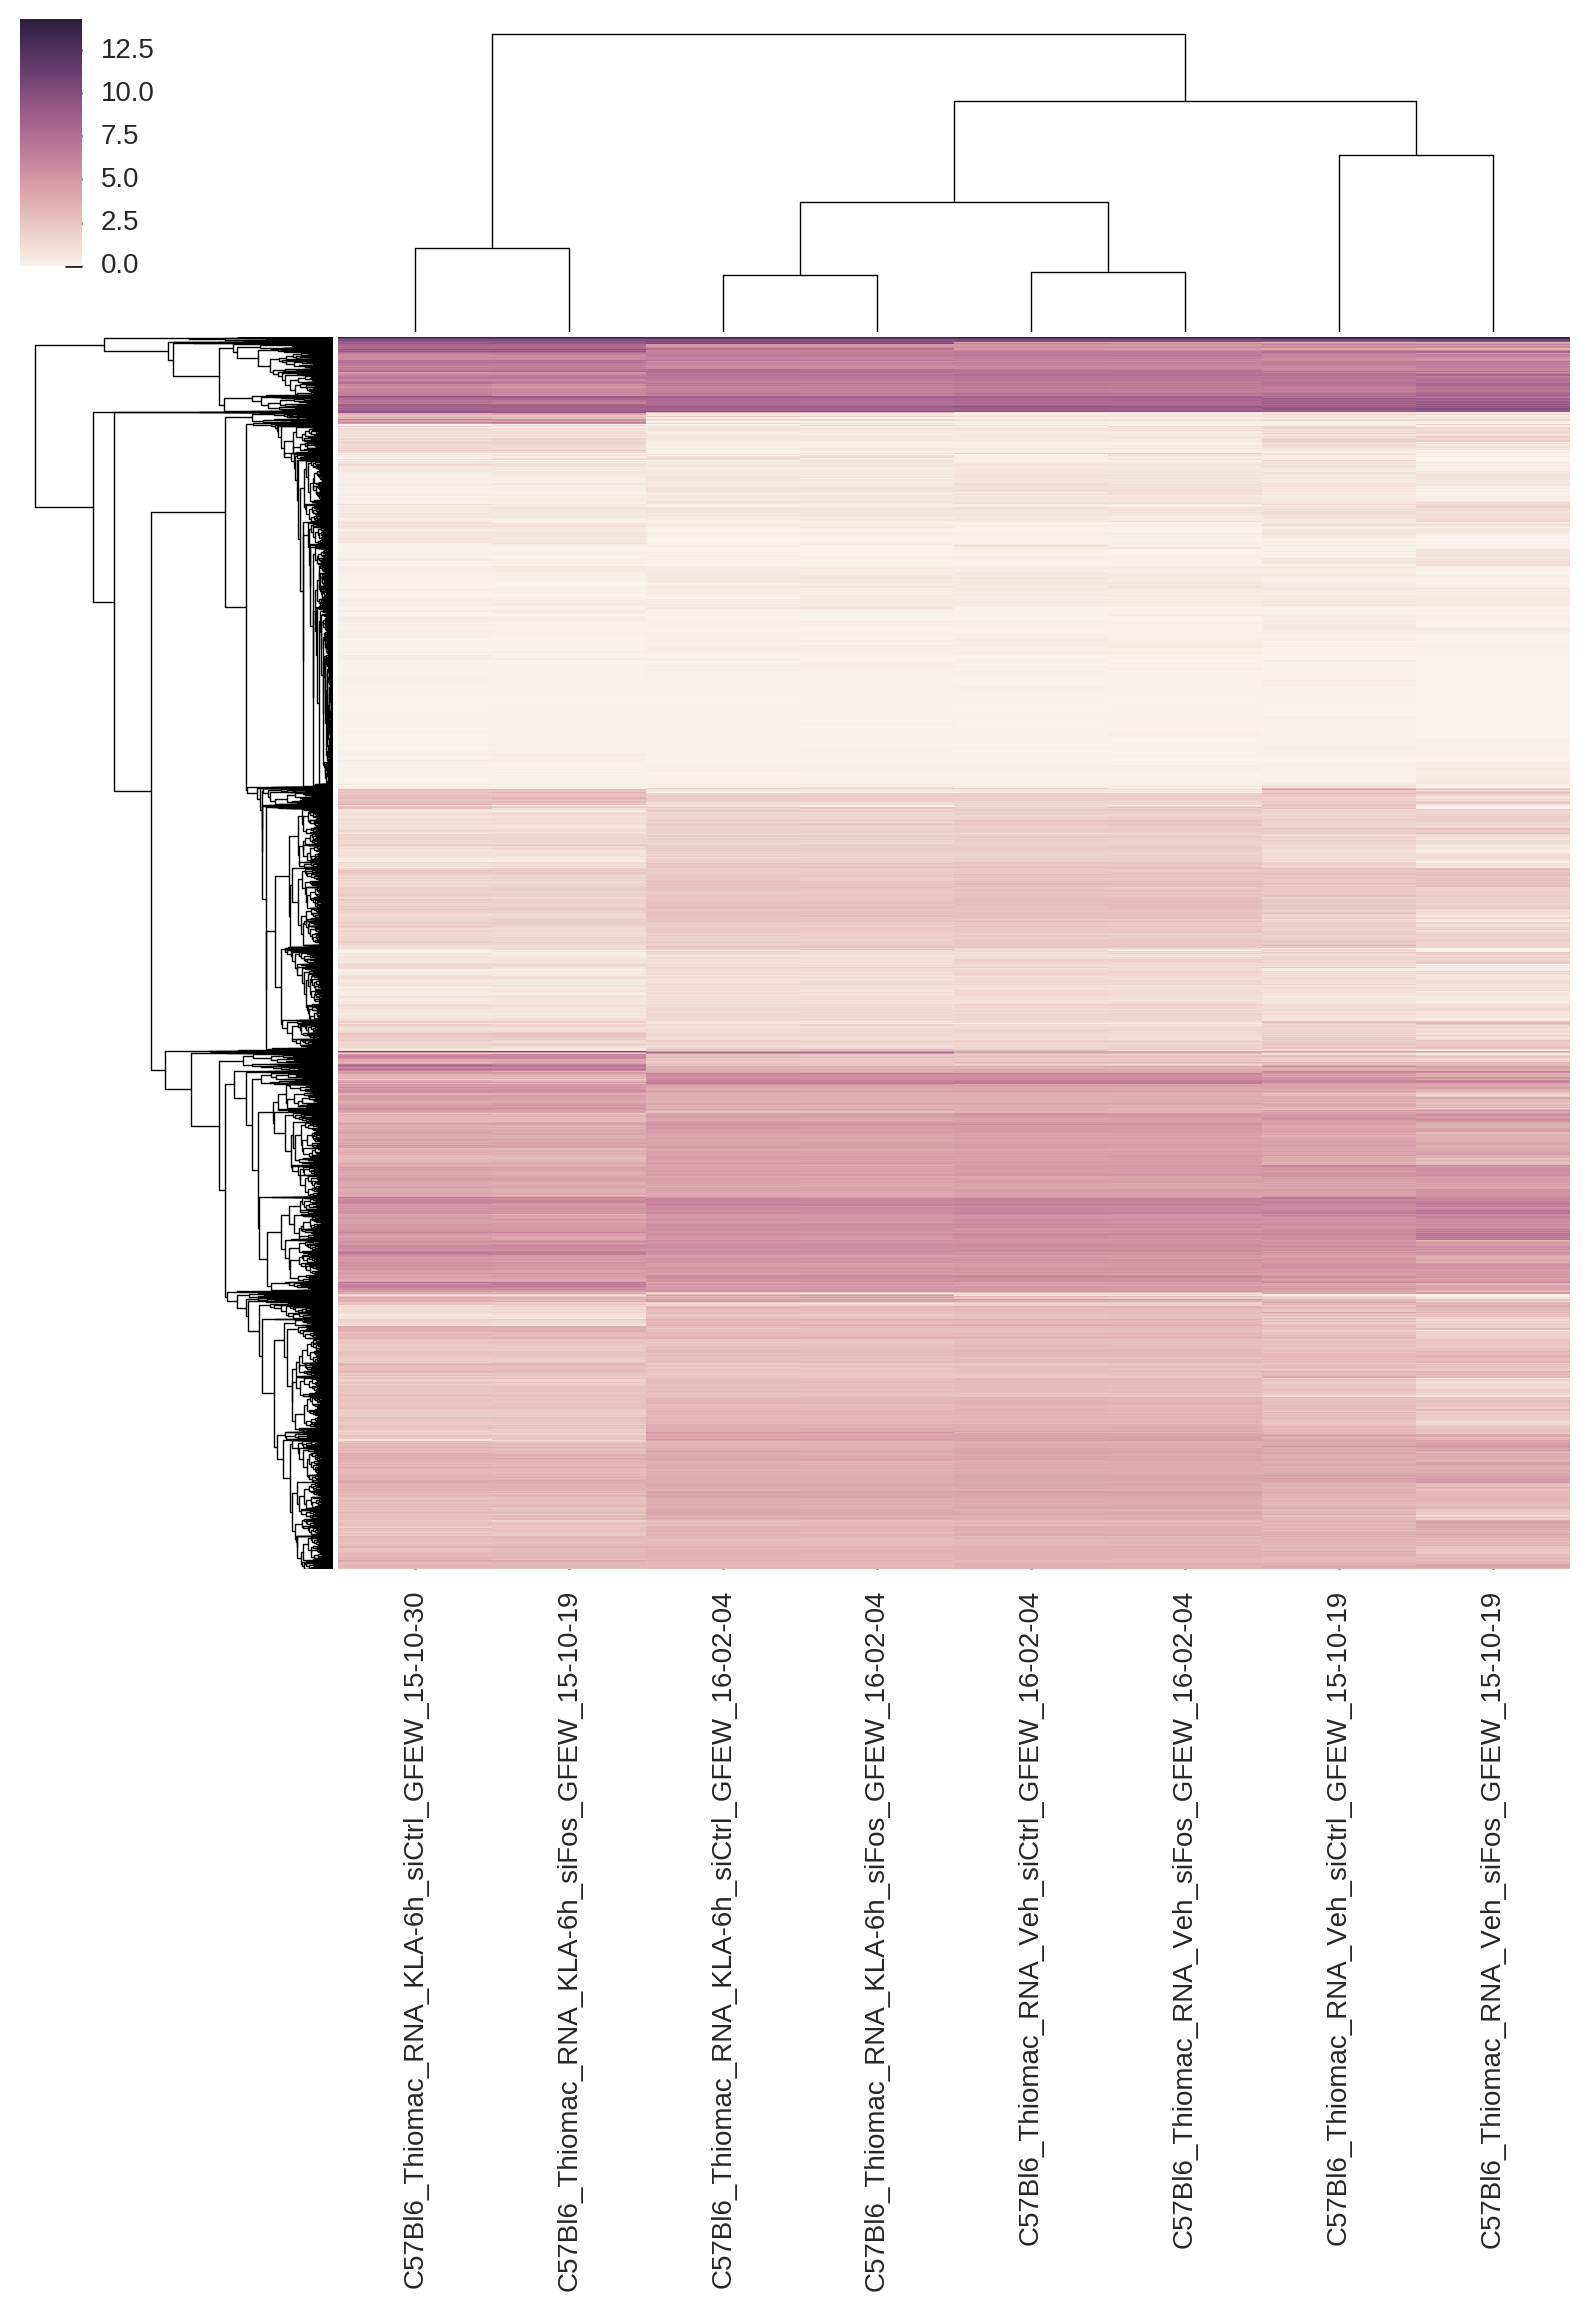

In [223]:
sns.clustermap(np.log2(filtered_rpkm_frame[[x for x in filtered_rpkm_frame.columns.values if 'siFos' in x or 'siCtrl' in x]] +1),
               yticklabels=False)